In [1]:
# %matplotlib widget
# Stdlib packages
import copy
import datetime
import glob
import json
import os
import re
import warnings
from pathlib import Path

# Common Py packages
import awkward as ak
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from prettytable import PrettyTable
from scipy.special import logit as inverse_sigmoid

# HEP packages
import gpustat
import h5py
import hist
import mplhep as hep
import xgboost as xgb
from cycler import cycler

# ML packages
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, fbeta_score
from scipy.integrate import trapezoid
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Module packages
from data_processing_BDT import process_data

gpustat.print_gpustat()

plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})
cmap_petroff10 = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
plt.rcParams.update({"axes.prop_cycle": cycler("color", cmap_petroff10)})

cmslpcgpu3.fnal.gov      Fri Jan 24 22:21:35 2025  555.42.06
[0] Tesla P100-PCIE-12GB | 41°C,   1 % |     0 / 12288 MB |


### File Locations and Model Naming

In [2]:
lpc_fileprefix = "/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v1"

FILEPATHS_DICT = {
    'ggF HH': [
        lpc_fileprefix+f"/Run3_2022preEE_merged_v5/GluGluToHH/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v5/GluGluToHH/nominal/*"
    ],
    # 'VBF HH': [
    #     lpc_fileprefix+f"/Run3_2022preEE_merged_v4/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*", 
    #     lpc_fileprefix+f"/Run3_2022postEE_merged_v4/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*"
    # ],
    'ttH': [
        lpc_fileprefix+f"/Run3_2022preEE_merged_v5/ttHToGG/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v5/ttHToGG/nominal/*"
    ],
    'VH': [
        # VH
        lpc_fileprefix+f"/Run3_2022preEE_merged_v5/VHToGG/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v5/VHToGG/nominal/*",
    ],
    'non-res + ggFH + VBFH': [
        # GG + 3Jets
        lpc_fileprefix+f"/Run3_2022preEE_merged_v5/GGJets/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v5/GGJets/nominal/*",
        # GJet pT 20-40
        lpc_fileprefix+f"/Run3_2022preEE_merged_v5/GJetPt20To40/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v5/GJetPt20To40/nominal/*",
        # GJet pT 40-inf
        lpc_fileprefix+f"/Run3_2022preEE_merged_v5/GJetPt40/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v5/GJetPt40/nominal/*",
        # ggF H
        lpc_fileprefix+f"/Run3_2022preEE_merged_v5/GluGluHToGG/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v5/GluGluHToGG/nominal/*",
        # VBF H
        lpc_fileprefix+f"/Run3_2022preEE_merged_v5/VBFHToGG/nominal/*", 
        lpc_fileprefix+f"/Run3_2022postEE_merged_v5/VBFHToGG/nominal/*",
    ],
    # 'single-H': [
    #     # ggF H
    #     lpc_fileprefix+f"/Run3_2022preEE_merged_v4/GluGluHToGG/nominal/*", 
    #     lpc_fileprefix+f"/Run3_2022postEE_merged_v4/GluGluHToGG/nominal/*",
    #     # VBF H
    #     lpc_fileprefix+f"/Run3_2022preEE_merged_v4/VBFHToGG/nominal/*", 
    #     lpc_fileprefix+f"/Run3_2022postEE_merged_v4/VBFHToGG/nominal/*",
    #     # VH
    #     lpc_fileprefix+f"/Run3_2022preEE_merged_v4/VHToGG/nominal/*", 
    #     lpc_fileprefix+f"/Run3_2022postEE_merged_v4/VHToGG/nominal/*",
    # ],
    # 'non-res': [
    #     # GG + 3Jets
    #     lpc_fileprefix+f"/Run3_2022preEE_merged_v4/GGJets/nominal/*", 
    #     lpc_fileprefix+f"/Run3_2022postEE_merged_v4/GGJets/nominal/*",
    #     # GJet pT 20-40
    #     lpc_fileprefix+f"/Run3_2022preEE_merged_v4/GJetPt20To40/nominal/*", 
    #     lpc_fileprefix+f"/Run3_2022postEE_merged_v4/GJetPt20To40/nominal/*",
    #     # GJet pT 40-inf
    #     lpc_fileprefix+f"/Run3_2022preEE_merged_v4/GJetPt40/nominal/*", 
    #     lpc_fileprefix+f"/Run3_2022postEE_merged_v4/GJetPt40/nominal/*",
    # ],
}

CURRENT_DIRPATH = str(Path().absolute())
VERSION = 'v7'
MOD_VALS = (5, 5)
# VARS = 'nonres_and_ttH_and_DNN_vars_no_diphoMass'
# CURRENT_TIME = '2025-01-23_09-59-35'
VARS = 'nonres_and_ttH_and_DNN_vars_no_badVars'
if 'CURRENT_TIME' in globals():
    OUTPUT_DIRPATH = os.path.join(CURRENT_DIRPATH, f"MultiClassBDT_model_outputs/{VERSION}/{VARS}", CURRENT_TIME)
else:
    OUTPUT_DIRPATH = os.path.join(CURRENT_DIRPATH, f"MultiClassBDT_model_outputs/{VERSION}/{VARS}")

if not os.path.exists(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

OTHER_BKG_RESCALE = 50
OPTIMIZE_SPACE = False

### Pre-processing Functions

In [3]:
def training_weights(event_weights, labels, order=None, weighttype='rescaled_and_shifted', sig_rescale_factor=None):
    if weighttype == 'abs':
        return np.abs(event_weights)
    
    if order is not None:
        sig_idx, big_bkg_idx = -1, -1
        for i, sample_name in enumerate(order):
            if re.search('ggF HH', sample_name) is not None:
                sig_idx = i
                continue
            if re.search('non-res', sample_name) is not None:
                big_bkg_idx = i
                continue
    else:
        sig_idx, big_bkg_idx = 0, len(order)-1
    
    if sig_rescale_factor is None:
        sig_sum = np.sum(event_weights[labels[:, sig_idx] == 1])
        bkg_sum = np.sum(event_weights[labels[:, sig_idx] == 0])
        
        sig_rescale_factor = bkg_sum / sig_sum

    scaled_weights = np.where(
        labels[:, sig_idx] == 0, 
        np.where(
            np.argmax(labels, axis=1) != big_bkg_idx,  
            event_weights * OTHER_BKG_RESCALE,  # if not big bkg, rescale
            event_weights  # otherwise do nothing
        ),
        event_weights * sig_rescale_factor  # if sig, rescale to equal sum of all bkgs
    )

    abs_weights = np.abs(scaled_weights)

    if weighttype == 'rescaled':
        return abs_weights
    elif weighttype == 'rescaled_and_shifted':
        mean_weights = np.mean(scaled_weights)
        rescaled_weights = abs_weights / mean_weights
        return rescaled_weights
    else:
        raise ValueError(
            f"The only options for weighttype are 'abs', 'rescaled', and 'rescaled_and_shifted'. You provided {weighttype}"
        )

# def training_weights(event_weights, labels, order=None, sig_rescale_factor=None):
#     if order is None:
#         order = [i for v in range(np.shape(labels)[0])]
#     sum_dict, max_sum, max_i = {}, 0, 0
#     for i, sample_name in enumerate(order):
#         sum_dict[i] = np.sum(event_weights[labels[:, i] == 1])
#         if np.sum(event_weights[labels[:, i] == 1]) > max_sum:
#             max_sum, max_i = np.sum(event_weights[labels[:, i] == 1]), i

#     label_i = np.sum(
#         np.tile([i for i in range(np.shape(labels)[1])], (np.shape(labels)[0], 1)) * labels,
#         axis=1
#     )

#     weight_factors = []
#     for i in range(len(label_i)):
#         weight_factors.append(
#             max_sum / sum_dict[label_i[i]] if label_i[i] != max_i else 1
#         )
#     weights = event_weights * np.array(weight_factors)

#     mean_weight = np.mean(weights)
#     abs_weights = np.abs(weights)
#     scaled_weights = abs_weights / mean_weight

#     return scaled_weights


def xgb_labels(labels):
    label_i = np.sum(
        np.tile([i for i in range(np.shape(labels)[1])], (np.shape(labels)[0], 1)) * labels,
        axis=1
    )

    return label_i

### Data Loading and Input Pre-processing

In [4]:
# order = ['ggF HH', 'ttH', 'single-H', 'non-res']
order = ['ggF HH', 'ttH', 'VH', 'non-res + ggFH + VBFH']

(
    sig_rescale_factor,
    data_df_dict, data_test_df_dict, 
    data_hlf_dict, label_dict,
    data_hlf_test_dict, label_test_dict, 
    hlf_vars_columns_dict,
    data_aux_dict, data_test_aux_dict
) = process_data(
    FILEPATHS_DICT, OUTPUT_DIRPATH, order=order, mod_vals=MOD_VALS,
    save=False if 'CURRENT_TIME' in globals() else True,
    std_json_dirpath=OUTPUT_DIRPATH if 'CURRENT_TIME' in globals() else None,
    other_bkg_rescale=OTHER_BKG_RESCALE
)

# Make xgb-like labels (NOT one-hot encoded, but integer encoded for each class)
xgb_label_dict = {
    f"fold_{fold_idx}": copy.deepcopy(xgb_labels(label_dict[f"fold_{fold_idx}"])) for fold_idx in range(len(data_test_aux_dict))
}
xgb_label_test_dict = {
    f"fold_{fold_idx}": copy.deepcopy(xgb_labels(label_test_dict[f"fold_{fold_idx}"])) for fold_idx in range(len(data_test_aux_dict))
}

# Make weight dicts:
#   - the top two are with the training rescale (i.e. rescale sig eventWeight to match bkg and then shift for gradients)
#   - the bottom two are the standard eventWeights (i.e. xs * lumi * genWeight) for proper plotting
weight_train_dict = {
    f"fold_{fold_idx}": copy.deepcopy(training_weights(data_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy(), label_dict[f'fold_{fold_idx}'], order=order, sig_rescale_factor=sig_rescale_factor)) for fold_idx in range(len(data_aux_dict))
}
weight_test_dict = {
    f'fold_{fold_idx}': copy.deepcopy(training_weights(data_test_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy(), label_test_dict[f'fold_{fold_idx}'], order=order, sig_rescale_factor=sig_rescale_factor)) for fold_idx in range(len(data_test_aux_dict))
}
weights_plot_train_dict = {
    f"fold_{fold_idx}": copy.deepcopy(data_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy()) for fold_idx in range(len(data_aux_dict))
}
weights_plot_test = {
    f'fold_{fold_idx}': copy.deepcopy(data_test_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy()) for fold_idx in range(len(data_test_aux_dict))
}

In [5]:
bdt_train_dict, bdt_val_dict, bdt_test_dict = {}, {}, {}

train_data_dict, val_data_dict = {}, {}
xgb_label_train_dict, xgb_label_val_dict = {}, {}
weights_plot_train, weights_plot_val= {}, {}
train_idxs_dict, val_idxs_dict = {}, {}
for fold_idx in range(len(data_df_dict)):
    if re.search('no_std', VARS) is not None:
        print('no standardization')
        train_val_data_dict = {key: value.to_numpy() for key, value in data_df_dict.items()}
        test_data_dict = {key: value.to_numpy() for key, value in data_test_df_dict.items()}
    else:
        train_val_data_dict = data_hlf_dict
        test_data_dict = data_hlf_test_dict
    (
        X_train, X_val, 
        y_train, y_val, 
        weight_train, weight_val, 
        weight_plot_train, weight_plot_val,
        train_idxs, val_idxs
    ) = train_test_split(
        train_val_data_dict[f"fold_{fold_idx}"], xgb_label_dict[f"fold_{fold_idx}"], 
        weight_train_dict[f"fold_{fold_idx}"], weights_plot_train_dict[f"fold_{fold_idx}"],
        range(len(train_val_data_dict[f"fold_{fold_idx}"])),
        test_size=0.2, random_state=21
    )

    train_data_dict[f"fold_{fold_idx}"] = copy.deepcopy(X_train)
    val_data_dict[f"fold_{fold_idx}"] = copy.deepcopy(X_val)

    xgb_label_train_dict[f"fold_{fold_idx}"] = copy.deepcopy(y_train)
    xgb_label_val_dict[f"fold_{fold_idx}"] = copy.deepcopy(y_val)

    weights_plot_train[f"fold_{fold_idx}"] = copy.deepcopy(weight_plot_train)
    weights_plot_val[f"fold_{fold_idx}"] = copy.deepcopy(weight_plot_val)

    train_idxs_dict[f"fold_{fold_idx}"] = copy.deepcopy(train_idxs)
    val_idxs_dict[f"fold_{fold_idx}"] = copy.deepcopy(val_idxs)

    bdt_train_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
        data=X_train, label=y_train, 
        weight=weight_train,
        missing=-999.0, feature_names=list(hlf_vars_columns_dict[f"fold_{fold_idx}"])
    )
    bdt_val_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
        data=X_val, label=y_val, 
        weight=weight_val,
        missing=-999.0, feature_names=list(hlf_vars_columns_dict[f"fold_{fold_idx}"])
    )
    
    bdt_test_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
        data=test_data_dict[f"fold_{fold_idx}"], label=xgb_label_test_dict[f"fold_{fold_idx}"], 
        weight=np.abs(weight_test_dict[f"fold_{fold_idx}"]),
        missing=-999.0, feature_names=list(hlf_vars_columns_dict[f"fold_{fold_idx}"])
    )

    print(f"fold {fold_idx}")
    print(f"Num train: {len(y_train)} -> {sum(y_train == 0)} sig & {sum(y_train == 1)} ttH bkg & {sum(y_train == 2)} single-H bkg & {sum(y_train == 3)} non-res bkg")
    print(f"Num val: {len(y_val)} -> {sum(y_val == 0)} sig & {sum(y_val == 1)} ttH bkg & {sum(y_val == 2)} single-H bkg & {sum(y_val == 3)} non-res bkg")
    print(f"Num test: {len(label_test_dict[f'fold_{fold_idx}'])} -> {sum(label_test_dict[f'fold_{fold_idx}'] == np.array([1, 0, 0, 0]))[0]} sig & {sum(label_test_dict[f'fold_{fold_idx}'] == np.array([0, 1, 0, 0]))[1]} ttH bkg & {sum(label_test_dict[f'fold_{fold_idx}'] == np.array([0, 0, 1, 0]))[2]} single-H bkg & & {sum(label_test_dict[f'fold_{fold_idx}'] == np.array([0, 0, 0, 1]))[3]} non-res bkg")
    print('='*60)

    

fold 0
Num train: 1250553 -> 109202 sig & 221813 ttH bkg & 107711 single-H bkg & 811827 non-res bkg
Num val: 312639 -> 27328 sig & 55392 ttH bkg & 26930 single-H bkg & 202989 non-res bkg
Num test: 391785 -> 34224 sig & 69297 ttH bkg & 33713 single-H bkg & & 254551 non-res bkg
fold 1
Num train: 1251336 -> 109538 sig & 221692 ttH bkg & 107855 single-H bkg & 812251 non-res bkg
Num val: 312835 -> 26928 sig & 55760 ttH bkg & 26850 single-H bkg & 203297 non-res bkg
Num test: 390806 -> 34288 sig & 69050 ttH bkg & 33649 single-H bkg & & 253819 non-res bkg
fold 2
Num train: 1250948 -> 109282 sig & 221260 ttH bkg & 108006 single-H bkg & 812400 non-res bkg
Num val: 312737 -> 27356 sig & 55367 ttH bkg & 26813 single-H bkg & 203201 non-res bkg
Num test: 391292 -> 34116 sig & 69875 ttH bkg & 33535 single-H bkg & & 253766 non-res bkg
fold 3
Num train: 1251535 -> 109354 sig & 221822 ttH bkg & 107689 single-H bkg & 812670 non-res bkg
Num val: 312884 -> 27317 sig & 55232 ttH bkg & 26926 single-H bkg & 2

### Model Parameterization

In [6]:
# https://stackoverflow.com/questions/57986259/multiclass-classification-with-xgboost-classifier
# https://forecastegy.com/posts/xgboost-multiclass-classification-python/
# https://indico.cern.ch/event/915265/contributions/3848138/attachments/2048174/3432202/kunlinRan_bbyy_20200531.pdf

# https://xgboost.readthedocs.io/en/stable/tutorials/intercept.html - for looking at logits level BDT output
# https://indico.cern.ch/event/915265/contributions/3848138/attachments/2048174/3432202/kunlinRan_bbyy_20200531.pdf - ATLAS HHbbgg BDT


param = {}

# Booster parameters
param['eta']              = 0.05 # learning rate
num_trees = round(25 / param['eta'])  # number of trees to make
# param['max_depth']        = 8  # maximum depth of a tree
# param['subsample']        = 1 # fraction of events to train tree on
# param['colsample_bytree'] = 0.33 # fraction of features to train tree on
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 0.6 # fraction of events to train tree on
param['colsample_bytree'] = 0.6 # fraction of features to train tree on
param['num_class']        = len(order) # num classes for multi-class training

# Learning task parameters
param['objective']   = 'multi:softprob'   # objective function
param['eval_metric'] = 'merror'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'mlogloss')]
# param["disable_default_eval_metric"] = True
# param = list(param.items())


def thresholded_weighted_merror(predt: np.ndarray, dtrain: xgb.DMatrix, threshold=0.95):
    """Used when there's no custom objective."""
    # No need to do transform, XGBoost handles it internally.
    weights = dtrain.get_weight()
    thresh_weight_merror = np.where(
        np.logical_and(
            np.max(predt, axis=1) >= threshold,
            np.argmax(predt, axis=1) == dtrain.get_label()
        ),
        0,
        weights
    )
    return f'WeightedMError@{threshold:.2f}', np.sum(thresh_weight_merror)

In [7]:
def optimize_hyperparams(
    dtrain_dict: dict, dval_dict: dict, dtest_dict: dict, param, verbose: bool=False, verbose_eval=False
):  
    rng = np.random.default_rng()

    space  = [
        Real(1e-3, 0.1, "log-uniform", name='eta'),
        Integer(1, 20, "uniform", name='max_depth'),
        Real(1e-3, 1., "log-uniform", name='subsample'),
        Real(0.1, 1., "uniform", name='colsample_bytree'),
        # Real(1e-4, 1., "log-uniform", name='alpha'),
        # Real(1e-4, 1., "log-uniform", name='lambda'),
    ]

    score_arrs = []

    @use_named_args(space)
    def objective(**X):
        if verbose:
            print("New configuration: {}".format(X))

        for key, val in X.items():
            param[key] = val
        num_trees = round(25 / X['eta'])

        # randomly sample a fold to evaluate
        fold_idx = rng.integers(0, 4)

        evallist = [(dtrain_dict[f"fold_{fold_idx}"], 'train'), (dtest_dict[f"fold_{fold_idx}"], 'test'), (dval_dict[f"fold_{fold_idx}"], 'val')]
        booster = xgb.train(
            param, dtrain_dict[f"fold_{fold_idx}"], num_boost_round=num_trees, 
            evals=evallist, early_stopping_rounds=10, verbose_eval=verbose_eval,
        )

        eval_str = booster.eval(dval_dict[f"fold_{fold_idx}"], name='val', iteration=booster.best_iteration)

        best_mlogloss = float(eval_str[eval_str.find('val-mlogloss:')+len('val-mlogloss:'):])
        score_arrs.append(best_mlogloss)

        if verbose:
            print(f"Best val. mlogloss on fold{fold_idx} = {best_mlogloss}")

        return -best_mlogloss
    
    res_gp = gp_minimize(objective, space)
    print("Best parameters: {}".format(res_gp.x))

    param['eta'] = float(res_gp.x[0])
    param['max_depth'] = int(res_gp.x[1])
    param['subsample'] = float(res_gp.x[2])
    param['colsample_bytree'] = float(res_gp.x[3])
    # param['alpha'] = float(res_gp.x[4])
    # param['lambda'] = float(res_gp.x[5])
    return param

### Model Training

In [13]:
if 'CURRENT_TIME' in globals():
    OUTPUT_DIRPATH, OLD_TIME = os.path.split(OUTPUT_DIRPATH)
CURRENT_TIME = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
OUTPUT_DIRPATH = os.path.join(OUTPUT_DIRPATH, CURRENT_TIME)
if not os.path.exists(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

if OPTIMIZE_SPACE:

    print('OPTIMIZING SPACE')

    param_dict = {}
    for name, value in param:
        if value == 'merror':
            continue
        param_dict[name] = value
        
    param = optimize_hyperparams(bdt_train_dict, bdt_val_dict, bdt_test_dict, param_dict, verbose=True, verbose_eval=50)

    with open(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_best_params.json'), 'w') as f:
        json.dump(param, f)
        print(param)

    param['eval_metric'] = 'merror'
    param = list(param.items()) + [('eval_metric', 'mlogloss')]

evals_result_dict = {f"fold_{fold_idx}": dict() for fold_idx in range(len(bdt_train_dict))}
for fold_idx in range(len(bdt_train_dict)):
    print(f"fold {fold_idx}")
    # Train bdt
    evallist = [(bdt_train_dict[f"fold_{fold_idx}"], 'train'), (bdt_test_dict[f"fold_{fold_idx}"], 'test'), (bdt_val_dict[f"fold_{fold_idx}"], 'val')]
    booster = xgb.train(
        param, bdt_train_dict[f"fold_{fold_idx}"], num_boost_round=num_trees, 
        evals=evallist, early_stopping_rounds=10, verbose_eval=25, evals_result=evals_result_dict[f"fold_{fold_idx}"],
        # custom_metric=thresholded_weighted_merror
    )

    booster.save_model(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))
    
    # Print perf on test dataset
    print(booster.eval(bdt_test_dict[f"fold_{fold_idx}"], name='test', iteration=booster.best_iteration))
    print('='*100)

with open(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_eval_result.json'), 'w') as f:
    json.dump(evals_result_dict, f)

fold 0
[0]	train-merror:0.07470	train-mlogloss:1.30402	test-merror:0.08756	test-mlogloss:1.30490	val-merror:0.08991	val-mlogloss:1.30538
[25]	train-merror:0.05210	train-mlogloss:0.45276	test-merror:0.06435	test-mlogloss:0.47111	val-merror:0.06710	val-mlogloss:0.47543
[50]	train-merror:0.04753	train-mlogloss:0.24527	test-merror:0.06161	test-mlogloss:0.27332	val-merror:0.06485	val-mlogloss:0.27861
[75]	train-merror:0.04373	train-mlogloss:0.17377	test-merror:0.05997	test-mlogloss:0.21025	val-merror:0.06308	val-mlogloss:0.21629
[100]	train-merror:0.04066	train-mlogloss:0.14494	test-merror:0.05923	test-mlogloss:0.18976	val-merror:0.06266	val-mlogloss:0.19620
[125]	train-merror:0.03799	train-mlogloss:0.12988	test-merror:0.05890	test-mlogloss:0.18175	val-merror:0.06245	val-mlogloss:0.18846
[150]	train-merror:0.03536	train-mlogloss:0.11983	test-merror:0.05924	test-mlogloss:0.17832	val-merror:0.06170	val-mlogloss:0.18526
[175]	train-merror:0.03286	train-mlogloss:0.11229	test-merror:0.05874	test

### Performance (ROC) Calculations

In [14]:
base_tpr = np.linspace(0, 1, 5000)  # copied from IN evaluate.py file
roc_baseline = np.zeros(
    (len(bdt_train_dict), len(base_tpr), len(order)), 
    dtype=float
)
area_baseline = np.zeros(
    (len(bdt_train_dict), len(order)), 
    dtype=float
)

BDT_perf = {
    sample_name: copy.deepcopy({
        'base_tpr': base_tpr,
        'class_order': copy.deepcopy(order),
        # test data #
        'preds': [],
        'fprs_density': copy.deepcopy(roc_baseline), 'thresholds_density': copy.deepcopy(roc_baseline), 'areas_density': copy.deepcopy(area_baseline),
        'fprs_weighted': copy.deepcopy(roc_baseline), 'thresholds_weighted': copy.deepcopy(roc_baseline), 'areas_weighted': copy.deepcopy(area_baseline),
        'fprs_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'thresholds_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'areas_sum_density': copy.deepcopy(area_baseline[0, ...]),
        'fprs_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'thresholds_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'areas_sum_weighted': copy.deepcopy(area_baseline[0, ...]),
        # train data #
        'train_preds': [], 
        'train_fprs_density': copy.deepcopy(roc_baseline), 'train_thresholds_density': copy.deepcopy(roc_baseline), 'train_areas_density': copy.deepcopy(area_baseline),
        'train_fprs_weighted': copy.deepcopy(roc_baseline), 'train_thresholds_weighted': copy.deepcopy(roc_baseline), 'train_areas_weighted': copy.deepcopy(area_baseline),
        'train_fprs_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'train_thresholds_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'train_areas_sum_density': copy.deepcopy(area_baseline[0, ...]),
        'train_fprs_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'train_thresholds_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'train_areas_sum_weighted': copy.deepcopy(area_baseline[0, ...]),
        # val data #
        'val_preds': [],
        'val_fprs_density': copy.deepcopy(roc_baseline), 'val_thresholds_density': copy.deepcopy(roc_baseline), 'val_areas_density': copy.deepcopy(area_baseline),
        'val_fprs_weighted': copy.deepcopy(roc_baseline), 'val_thresholds_weighted': copy.deepcopy(roc_baseline), 'val_areas_weighted': copy.deepcopy(area_baseline),
        'val_fprs_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'val_thresholds_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'val_areas_sum_density': copy.deepcopy(area_baseline[0, ...]),
        'val_fprs_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'val_thresholds_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'val_areas_sum_weighted': copy.deepcopy(area_baseline[0, ...]),
    }) for sample_name in order
}

for j, sample_name in enumerate(order):

    for fold_idx in range(len(bdt_train_dict)):
        booster = xgb.Booster(param)

        try:
            booster.load_model(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))
        except:
            raise FileNotFoundError(f"No model file at fold {fold_idx}.")
    
        for pred_type, dataset in [
            ('train_', bdt_train_dict[f"fold_{fold_idx}"]),
            ('val_', bdt_val_dict[f"fold_{fold_idx}"]),
            ('', bdt_test_dict[f"fold_{fold_idx}"])
        ]:
            
            BDT_perf[sample_name][pred_type + 'preds'].append(
                booster.predict(
                    dataset, 
                    iteration_range=(0, booster.best_iteration+1)
                ).tolist()
            )

            for i, sample_name_ in enumerate(order):
                
                if sample_name_ == sample_name:
                    event_mask = dataset.get_label() > -1
                    pred_rescale = np.ones_like(event_mask)
                else:
                    event_mask = np.logical_or(dataset.get_label() == j, dataset.get_label() == i)
                    pred_rescale = np.array(BDT_perf[sample_name][pred_type + 'preds'][-1])[:, j][event_mask] + np.array(BDT_perf[sample_name][pred_type + 'preds'][-1])[:, i][event_mask]
                class_preds = np.array(BDT_perf[sample_name][pred_type + 'preds'][-1])[:, j][event_mask] / pred_rescale
                class_truths = np.where(dataset.get_label() == j, 1, 0)[event_mask]
                
                for roc_type in ['density', 'weighted']:

                    if roc_type == 'weighted':
                        if re.search('train', pred_type) is not None:
                            roc_weights = weights_plot_train[f"fold_{fold_idx}"][event_mask]
                        elif re.search('val', pred_type) is not None:
                            roc_weights = weights_plot_val[f"fold_{fold_idx}"][event_mask]
                        else:
                            roc_weights = weights_plot_test[f"fold_{fold_idx}"][event_mask]
                    else:
                        roc_weights = None

                    fpr_bdt, tpr_bdt, threshold_bdt = roc_curve(class_truths, class_preds, sample_weight=roc_weights)
                    fpr_bdt = np.interp(base_tpr, tpr_bdt, fpr_bdt)
                    threshold_bdt = np.interp(base_tpr, tpr_bdt, threshold_bdt)

                    BDT_perf[sample_name][pred_type + 'fprs_' + roc_type][fold_idx][:, i] = fpr_bdt
                    BDT_perf[sample_name][pred_type + 'thresholds_' + roc_type][fold_idx][:, i] = threshold_bdt
                    BDT_perf[sample_name][pred_type + 'areas_' + roc_type][fold_idx][i] = float(trapezoid(base_tpr, fpr_bdt))
    
    for pred_type, dataset_dict in [
        ('train_', bdt_train_dict),
        ('val_', bdt_val_dict),
        ('', bdt_test_dict)
    ]:

        flat_preds = np.concatenate(BDT_perf[sample_name][f'{pred_type}preds'], axis=0)
        flat_truths = np.concatenate([dataset_dict[f"fold_{fold_idx}"].get_label() for fold_idx in range(len(dataset_dict))], axis=0)

        for i, sample_name_ in enumerate(order):
            
            if sample_name_ == sample_name:
                event_mask = flat_truths > -1
                pred_rescale = np.ones_like(event_mask)
            else:
                event_mask = np.logical_or(flat_truths == j, flat_truths == i)
                pred_rescale = flat_preds[:, j][event_mask] + flat_preds[:, i][event_mask]
            class_preds = flat_preds[:, j][event_mask] / pred_rescale
            class_truths = np.where(flat_truths == j, 1, 0)[event_mask]
            
            for roc_type in ['density', 'weighted']:

                if roc_type == 'weighted':
                    if re.search('train', pred_type) is not None:
                        roc_weights = np.concatenate([weights_plot_train[f"fold_{fold_idx}"] for fold_idx in range(len(weights_plot_train))], axis=0)[event_mask]
                    elif re.search('val', pred_type) is not None:
                        roc_weights = np.concatenate([weights_plot_val[f"fold_{fold_idx}"] for fold_idx in range(len(weights_plot_val))], axis=0)[event_mask]
                    else:
                        roc_weights = np.concatenate([weights_plot_test[f"fold_{fold_idx}"] for fold_idx in range(len(weights_plot_test))], axis=0)[event_mask]
                else:
                    roc_weights = None

                fpr_bdt, tpr_bdt, threshold_bdt = roc_curve(class_truths, class_preds, sample_weight=roc_weights)
                fpr_bdt = np.interp(base_tpr, tpr_bdt, fpr_bdt)
                threshold_bdt = np.interp(base_tpr, tpr_bdt, threshold_bdt)

                BDT_perf[sample_name][pred_type + 'fprs_sum_' + roc_type][:, i] = fpr_bdt
                BDT_perf[sample_name][pred_type + 'thresholds_sum_' + roc_type][:, i] = threshold_bdt
                BDT_perf[sample_name][pred_type + 'areas_sum_' + roc_type][i] = float(trapezoid(base_tpr, fpr_bdt))
    
    for key in BDT_perf[sample_name].keys():
        if type(BDT_perf[sample_name][key]) is list:
            continue
        BDT_perf[sample_name][key] = BDT_perf[sample_name][key].tolist()


with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+f"_BDT_perf.json"), 'w') as f:
    json.dump(BDT_perf, f)


### Plotting Functions

In [8]:
def pad_list(list_of_lists):
    max_length = np.max([len(list_i) for list_i in list_of_lists])
    for list_i in list_of_lists:
        while len(list_i) < max_length:
            list_i.append(list_i[-1])

    return list_of_lists

def plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='png'):
    plot_prefix = plot_prefix + ('_' if plot_prefix != '' else '')
    plot_postfix = plot_postfix + ('_' if plot_postfix != '' else '')
    plot_name = plot_prefix + plot_name + plot_postfix + f'.{format}'

    plot_filepath = os.path.join(plot_dirpath, plot_name)
    return plot_filepath

def plot_train_val_losses(
    losses_arrs, labels, plot_name, plot_dirpath, 
    plot_prefix='', plot_postfix='', linestyles=None,
    losses_std_arrs=None
):
    plt.figure(figsize=(9,7))
    
    if type(losses_arrs[0]) is float:
        losses_arrs = [losses_arrs]
    if linestyles is None:
        linestyles = ['solid'] * len(losses_arrs)
    if labels is None:
        labels = [i for i in range(len(losses_arrs))]

    if losses_std_arrs is not None:
        for i in range(len(losses_std_arrs)):
            plt.fill_between(
                range(len(losses_std_arrs[i])), 
                losses_arrs[i]+losses_std_arrs[i], losses_arrs[i]-losses_std_arrs[i],
                alpha=0.7
            )

    for i in range(len(losses_arrs)):
        plt.plot(
            range(len(losses_arrs[i])), 
            losses_arrs[i], 
            label=f"{labels[i]} losses", linestyle=linestyles[i],
            alpha=0.7
        )
        
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('EPOCH')
    plt.ylabel('Data Loss')
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

def plot_rocs(
    fprs, tprs, labels, plot_name, plot_dirpath,
    plot_prefix='', plot_postfix='', close=True, log=None
):
    plt.figure(figsize=(9,7))
    
    for fpr, tpr, label in zip(fprs, tprs, labels):
        linestyle = 'solid' if re.search('IN', label) is not None else ('dashed' if re.search('BDT', label) is not None else 'dotted')
        plt.plot(fpr, tpr, label=label, linestyle=linestyle)

    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Background contamination')
    plt.ylabel('Signal efficiency')
    if log is not None and re.search('x', log) is not None:
        plt.xscale('log')
    elif log is not None and re.search('y', log) is not None:
        plt.yscale('log')
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    if close:
        plt.close()

def plot_output_scores(
    sigs_and_bkgs, order, plot_name, plot_dirpath,
    plot_prefix='', plot_postfix='', bins=1000, weights=None, log=False, arctanh=False
):
    plt.figure(figsize=(9,7))

    if arctanh:
        end_point = 6.
    else:
        end_point = 1.
    hist_axis = hist.axis.Regular(bins, 0., end_point, name='var', growth=False, underflow=False, overflow=False)
    hists, labels = [], []
    for sample_name in order:
        if sample_name not in sigs_and_bkgs:
            continue
        hists.append(
            hist.Hist(hist_axis, storage='weight').fill(
                var=sigs_and_bkgs[sample_name], 
                weight=weights[sample_name] if weights is not None else np.ones_like(sigs_and_bkgs[sample_name])
            )
        )
        labels.append(sample_name)
    hep.histplot(
        hists,
        yerr=(True if weights is not None else False),
        alpha=0.2, density=(False if weights is not None else True), histtype='step',
        label=labels
    )

    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Output score')
    if log:
        plt.yscale('log')
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

def plot_s_over_root_b(
    sig, bkg, label, plot_name, plot_dirpath,
    plot_prefix='', plot_postfix='', bins=1000, weights={'sig': None, 'bkg': None},
    lines=None, lines_labels=None, line_colors=None, arctanh=False
):
    plt.figure(figsize=(9,7))

    if arctanh:
        end_point = 6.
        hist_axis = hist.axis.Regular(bins, 0., end_point, name='var', growth=False, underflow=False, overflow=False)
    else:
        end_point = 1.
        hist_axis = hist.axis.Regular(bins, 0., end_point, name='var', growth=False, underflow=False, overflow=False)
    sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig, weight=weights['sig'] if weights['sig'] is not None else np.ones_like(sig))
    bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg, weight=weights['bkg'] if weights['bkg'] is not None else np.ones_like(bkg))
    s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
    plt.plot(
        np.arange(0., end_point, end_point*(1/bins)), s_over_root_b_points, 
        label=f'{label} - s/√b', alpha=0.8
    )

    if lines is not None:
        for i in range(len(lines)):
            plt.vlines(
                lines[i], 0, np.max(s_over_root_b_points), 
                label='s/√b'+(' - '+lines_labels[i] if lines_labels is not None else ''), 
                alpha=0.5, colors=line_colors[i]
            )
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Output score')
    plt.ylabel('s/√b')
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

def plot_confusion_matrix(
    conf_matrix, class_labels, plot_name, plot_dirpath, 
    plot_prefix='', plot_postfix=''
):
    plt.figure(figsize=(9,7))

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
    disp.plot(im_kw={'norm': 'log'})
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

def plot_feature_importance(
    feature_scores, feature_labels, plot_name, plot_dirpath, 
    plot_prefix='', plot_postfix='', fscore_method='total_gain', log=True
):
    plt.figure(figsize=(18,14))

    plt.barh(
        np.arange(len(feature_scores)), feature_scores, align='center'
    )
    plt.yticks(np.arange(len(feature_scores)), feature_labels, fontsize=8)
    plt.ylabel('Features')
    plt.xlabel(f'F score ({fscore_method})')
    if log:
        plt.xscale('log')
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

In [9]:
def optimize_cut_boundaries(sigs, bkgs, weights, bins=10000, arctanh=False):
    hist_list_fold = []
    cut_boundaries_fold = []
    cut_s_over_root_bs_fold = []
    sig_weights_fold = []
    bkg_weights_fold = []
    if len(np.shape(sigs)) == 1:
        sigs, bkgs = [sigs], [bkgs] 
    if arctanh:
        end_point = 6.
    else:
        end_point = 1.
    for sig, bkg in zip(sigs, bkgs):
        hist_axis = hist.axis.Regular(bins, 0., end_point, name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig, weight=weights['sig'])
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg, weight=weights['bkg'])
        hist_list_fold.append({'sig': copy.deepcopy(sig_hist), 'bkg': copy.deepcopy(bkg_hist)})

        fold_idx_cuts_bins_inclusive = []
        fold_idx_sig_weights = []
        fold_idx_bkg_weights = []
        fold_idx_prev_s_over_root_b = []
        prev_s_over_root_b = 0
        for i in range(bins):
            s = np.sum(sig_hist.values().flatten()[
                (bins-1) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
            ])
            sqrt_b = np.sqrt(np.sum(bkg_hist.values().flatten()[
                (bins-1) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
            ]))
            if prev_s_over_root_b < (s / sqrt_b) or s < 0.25:
                prev_s_over_root_b = s / sqrt_b
                continue
            else:
                fold_idx_sig_weights.append(
                    {
                        'value': np.sum(sig_hist.values().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ]),
                        'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ])),
                    }
                )
                fold_idx_bkg_weights.append(
                    {
                        'value': np.sum(bkg_hist.values().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ]),
                        'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ])),
                    }
                )
                fold_idx_cuts_bins_inclusive.append(bins - i)
                fold_idx_prev_s_over_root_b.append(prev_s_over_root_b)
                prev_s_over_root_b = 0
        fold_idx_sig_weights.append(
            {
                'value': np.sum(sig_hist.values().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ]),
                'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ])),
            }
        )
        fold_idx_bkg_weights.append(
            {
                'value': np.sum(bkg_hist.values().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ]),
                'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ])),
            }
        )
        fold_idx_cuts_bins_inclusive.append(0)
        fold_idx_prev_s_over_root_b.append(prev_s_over_root_b)
        fold_idx_score_cuts = [end_point * (bin_i / bins) for bin_i in fold_idx_cuts_bins_inclusive]
        cut_boundaries_fold.append(fold_idx_score_cuts)
        cut_s_over_root_bs_fold.append(fold_idx_prev_s_over_root_b)
        sig_weights_fold.append(fold_idx_sig_weights)
        bkg_weights_fold.append(fold_idx_bkg_weights)
    return cut_boundaries_fold, cut_s_over_root_bs_fold, sig_weights_fold, bkg_weights_fold

def p_to_xyz(p, split=True):  # makes a tetrahedron with height 1 and vertices {(0, 0, 0),  (√3/2, 0, √3/2),  (0, √3/2, √3/2),  (√3/2, √3/2, 0)}
    rt3o2 = np.sqrt(3) / 2

    x = rt3o2 * (0*p[:, 0] + p[:, 1] + p[:, 2] + 0*p[:, 3])
    y = rt3o2 * (0*p[:, 0] + 0*p[:, 1] + p[:, 2] + p[:, 3])
    z = rt3o2 * (0*p[:, 0] + p[:, 1] + 0*p[:, 2] + p[:, 3])

    if split:
        return x, y, z
    else:
        return np.column_stack((x, y, z))

def optimize_cuts(
    preds: np.ndarray, binary_labels: np.ndarray, weights: np.ndarray,
    init_guess=[1e-9, 2e-3, 1e-2], param_names=['r1', 'r2', 'r3'], param_range=[(1e-11, 1e-4), (1e-3, 5e-2), (0., 1.)], 
    n_steps=int(5e2), verbose: bool=False, min_sig: float=0.2, prefactor: float=1e3, rng_seed: int=21
):
    xyz_preds = p_to_xyz(preds, split=False)

    space  = [Real(float(param_range[i][0]), float(param_range[i][1]), ("log-uniform" if param_name == 'r4' else "uniform"), name=param_name) for i, param_name in enumerate(param_names)]

    def space_transform(X):
        triangle_vertices = X['r1']**(1/3) * np.array([
            [np.sqrt(3)/2,         0,            np.sqrt(3)/2], 
            [0,                np.sqrt(3)/2,     np.sqrt(3)/2], 
            [np.sqrt(3)/2,     np.sqrt(3)/2,                0]
        ])

        sampled_point = (
            (1 - np.sqrt((1 - X['r2']))) * triangle_vertices[0, :]
        ) + (
            np.sqrt((1 - X['r2']))*(1 - X['r3']) * triangle_vertices[1, :]
        ) + (
            np.sqrt((1 - X['r2']))*X['r3'] * triangle_vertices[2, :]
        )

        if verbose:
            print(sampled_point)

        return sampled_point

    @use_named_args(space)
    def objective(**X):
        if verbose:
            print("New configuration: {}".format(X))

        thresholds = space_transform(X)
        sample_mask = np.all(xyz_preds < thresholds, axis=1)

        # print(f"total sig = {np.sum(weights[binary_labels == 1])}")
        # print(f"total bkg = {np.sum(weights[binary_labels == 0])}")

        num_sig = np.abs(
            np.sum(
                weights[
                    np.logical_and(
                        binary_labels == 1,
                        sample_mask
                    )
                ]
            )
        )

        num_bkg = np.abs(
            np.sum(
                weights[
                    np.logical_and(
                        binary_labels == 0,
                        sample_mask
                    )
                ]
            )
        )

        s_over_root_b = num_sig / np.sqrt(num_bkg)

        if num_sig == 0 and num_bkg == 0:
            both_0 = prefactor*1e1
            if verbose:
                print(f"both sig and bkg 0 at this hyperplane => {both_0}")
            return both_0
        elif num_sig < min_sig:
            small_sig = prefactor*0
            if verbose:
                print(f"too little sig ({num_sig}) at this hyperplane => {small_sig}")
            return small_sig
        elif num_bkg == 0:
            zero_bkg = -prefactor*num_sig
            if verbose:
                print(f"zero bkg at this hyperplane (likely due to finite data rather than real bkg-free zone) => {zero_bkg}")
            return zero_bkg
        
        if verbose:
            print(f"s/√b = {s_over_root_b}, s = {num_sig}, b = {num_bkg}")

        return -prefactor*s_over_root_b
    
    res_gp = gp_minimize(
        objective, space, random_state=rng_seed, 
        n_calls=(n_steps + (1 if len(np.shape(init_guess)) == 1 else np.shape(init_guess)[0])), 
        n_initial_points=n_steps, x0=init_guess
    )

    opt_params = [float(res_gp.x[i]) for i in range(len(space))]
    opt_cuts = [float(opt_cut) for opt_cut in space_transform({param_names[i]: res_gp.x[i] for i in range(len(param_names))})]
    if verbose:
        print("Best parameters: {}".format(opt_cuts))
        print(f"Best s/√b = {-res_gp.fun / prefactor}")

    return opt_cuts, opt_params


def multi_optimize_cut_boundaries(preds: list, binary_labels: np.ndarray, weights: np.ndarray, num_categories: int=3, min_sig: float=0.2):
    init_param_range = [(1e-8, 1e-7), (1e-6, 1e-5), (1e-2, 1e-1)]
    init_guess = [5e-8, 5e-6, 5e-2]
    clf_dict = {}
    param_clf_dict = {}
    for cat in range(num_categories):

        clf_dict[cat] = []
        param_clf_dict[cat] = []

        if cat == 0:
            sliced_preds = np.array(preds)
            sliced_labels = binary_labels
            sliced_weights = weights
            param_range = init_param_range
            guess = init_guess

        else:
            slice_array = np.ones_like(binary_labels, dtype=bool)
            for prev_cat in range(cat):
                slice_array = np.logical_and(
                    slice_array,
                    np.logical_not(
                        np.all(
                            p_to_xyz(np.array(preds), split=False) < clf_dict[prev_cat], 
                            axis=1
                        )
                    )
                )

            sliced_preds = np.array(preds)[slice_array]
            sliced_labels = binary_labels[slice_array]
            sliced_weights = weights[slice_array]
            # param_range = [(param_clf_dict[cat-1][0], init_param_range[0][1]), (param_clf_dict[cat-1][1], init_param_range[1][1]), init_param_range[2]]
            # guess = [param_clf_dict[cat-1][0] + 1e-11, param_clf_dict[cat-1][1] + 1e-11, 0.5 * init_param_range[2][1]]
            param_range = init_param_range
            guess = init_guess
            
        opt_cuts, opt_params = optimize_cuts(
            sliced_preds, sliced_labels, sliced_weights, verbose=False,
            param_range=param_range, init_guess=guess, n_steps=200, min_sig=min_sig, rng_seed=None
        )

        clf_dict[cat] = opt_cuts
        param_clf_dict[cat] = opt_params

    return clf_dict



In [10]:
MC_NAMES_PRETTY = {
    "GGJets": r"$\gamma\gamma+3j$",
    "GJetPt20To40": r"$\gamma+j$, 20<$p_T$<40GeV",
    "GJetPt40": r"$\gamma+j$, 40GeV<$p_T$",
    "GluGluHToGG": r"ggF $H\rightarrow \gamma\gamma$",
    "VBFHToGG": r"VBF $H\rightarrow \gamma\gamma$",
    "VHToGG": r"V$H\rightarrow\gamma\gamma$",
    "ttHToGG": r"$t\bar{t}H\rightarrow\gamma\gamma$",
    "GluGluToHH": r"ggF $HH\rightarrow bb\gamma\gamma$",
    # "VBFHHto2B2G_CV_1_C2V_1_C3_1": r"VBF $HH\rightarrow bb\gamma\gamma$",
    "signal": r"ggF $HH\rightarrow bb\gamma\gamma$ + VBF $HH\rightarrow bb\gamma\gamma$",
    # Names for order #
    "ggF HH": r"ggF $H\rightarrow \gamma\gamma$",
    "ttH": r"$t\bar{t}H\rightarrow\gamma\gamma$",
    "single-H": r"ggF $H\rightarrow \gamma\gamma$ + VBF $H\rightarrow \gamma\gamma$ + V$H\rightarrow\gamma\gamma$",
    "non-res": r"$\gamma\gamma+3j$ + $\gamma+j$, 20GeV<$p_T$",
    "VH": r"V$H\rightarrow\gamma\gamma$",
    "non-res + ggFH + VBFH": r"$\gamma\gamma+3j$ + $\gamma+j$, 20GeV<$p_T$ + ggF $H\rightarrow \gamma\gamma$ + VBF $H\rightarrow \gamma\gamma$"
    # Need to fill in pretty print for BSM samples #
}
LUMINOSITIES = {
    '2022preEE': 7.9804, 
    '2022postEE': 26.6717,
    # Need to fill in lumis for other eras #
}
LUMINOSITIES['total_lumi'] = sum(LUMINOSITIES.values())

# Dictionary of variables
VARIABLES = {
    # key: hist.axis axes for plotting #
    # MET variables
    'puppiMET_sumEt': hist.axis.Regular(40, 150., 2000, name='var', label=r'puppiMET $\Sigma E_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'puppiMET $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_phi': hist.axis.Regular(20,-3.2, 3.2, name='var', label=r'puppiMET $\phi$', growth=False, underflow=False, overflow=False), 
    # jet-MET variables
    'DeltaPhi_j1MET': hist.axis.Regular(20,-3.2, 3.2, name='var', label=r'$\Delta\phi (j_1,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    'DeltaPhi_j2MET': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\Delta\phi (j_2,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    # jet-photon variables
    'DeltaR_jg_min': hist.axis.Regular(30, 0, 5, name='var', label=r'min$(\Delta R(jet, \gamma))$', growth=False, underflow=False, overflow=False), 
    # jet variables
    # 'jet1_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    # 'jet2_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'sublead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'lead_bjet_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead bjet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'lead_bjet_eta': hist.axis.Regular(20, -5., 5., name='var', label=r'lead bjet $\eta$', growth=False, underflow=False, overflow=False),
    'lead_bjet_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'lead bjet $\phi$', growth=False, underflow=False, overflow=False),
    'sublead_bjet_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead bjet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'sublead_bjet_eta': hist.axis.Regular(20, -5., 5., name='var', label=r'lead bjet $\eta$', growth=False, underflow=False, overflow=False),
    'sublead_bjet_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'lead bjet $\phi$', growth=False, underflow=False, overflow=False),
    'n_jets': hist.axis.Integer(0, 10, name='var', label=r'$n_{jets}$', growth=False, underflow=False, overflow=False), 
    'chi_t0': hist.axis.Regular(40, 0., 150, name='var', label=r'$\chi_{t0}^2$', growth=False, underflow=False, overflow=False), 
    'chi_t1': hist.axis.Regular(30, 0., 500, name='var', label=r'$\chi_{t1}^2$', growth=False, underflow=False, overflow=False), 
    # lepton variables
    'n_leptons': hist.axis.Integer(0, 10, name='var', label=r'$n_{leptons}$', growth=False, underflow=False, overflow=False),
    'lepton1_pt': hist.axis.Regular(40, 0., 200., name='var', label=r'lead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton2_pt': hist.axis.Regular(40, 0., 200., name='var', label=r'sublead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton1_eta': hist.axis.Regular(30, -5., 5., name='var', label=r'lead lepton $\eta$', growth=False, underflow=False, overflow=False), 
    'lepton2_eta': hist.axis.Regular(30, -5., 5., name='var', label=r'sublead lepton $\eta$', growth=False, underflow=False, overflow=False),
    'lepton1_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'lead lepton $\phi$', growth=False, underflow=False, overflow=False), 
    'lepton2_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'sublead lepton $\phi$', growth=False, underflow=False, overflow=False),
    # diphoton variables
    'pt': hist.axis.Regular(40, 20., 2000, name='var', label=r' $\gamma\gamma p_{T}$ [GeV]', growth=False, underflow=False, overflow=False),
    'eta': hist.axis.Regular(20, -5., 5., name='var', label=r'$\gamma\gamma \eta$', growth=False, underflow=False, overflow=False), 
    'phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\gamma \gamma \phi$', growth=False, underflow=False, overflow=False),
    # angular (cos) variables
    'abs_CosThetaStar_CS': hist.axis.Regular(20, 0, 1, name='var', label=r'|cos$(\theta_{CS})$|', growth=False, underflow=False, overflow=False), 
    'abs_CosThetaStar_jj': hist.axis.Regular(20, 0, 1, name='var', label=r'|cos$(\theta_{jj})$|', growth=False, underflow=False, overflow=False),
    'CosThetaStar_CS': hist.axis.Regular(20, -1, 1, name='var', label=r'cos$(\theta_{CS})$', growth=False, underflow=False, overflow=False), 
    'CosThetaStar_jj': hist.axis.Regular(20, -1, 1, name='var', label=r'cos$(\theta_{jj})$', growth=False, underflow=False, overflow=False), 
    # jet-lepton variables
    'leadBjet_leadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{lead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'leadBjet_subleadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{lead}, l_{sublead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_leadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{sublead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_subleadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{sublead}, l_{sublead})$', growth=False, underflow=False, overflow=False),
    # dijet variables (must be blinded on data)
    'dijet_mass': hist.axis.Regular(25, 25., 180., name='var', label=r'$M_{jj}$ [GeV]', growth=False, underflow=False, overflow=False),
    # diphoton variables (must be blinded on data)
    'mass': hist.axis.Regular(25, 25., 180., name='var', label=r'$M_{\gamma\gamma}$ [GeV]', growth=False, underflow=False, overflow=False),
    # Yibo's BDT variables
    'lead_mvaID': hist.axis.Regular(50, -1., 1., name='var', label=r'$\gamma_{lead}$ MVA ID', growth=False, underflow=False, overflow=False), 
    'sublead_mvaID': hist.axis.Regular(50, -1., 1., name='var', label=r'$\gamma_{sublead}$ MVA ID', growth=False, underflow=False, overflow=False),
    'CosThetaStar_gg': hist.axis.Regular(50, -1., 1., name='var', label=r'cos$(\theta_{gg})$', growth=False, underflow=False, overflow=False),
    'lead_pt_over_Mgg': hist.axis.Regular(50, 0., 1., name='var', label=r'$p_{T,\gamma_1} / M_{\gamma\gamma}$', growth=False, underflow=False, overflow=False), 
    'sublead_pt_over_Mgg': hist.axis.Regular(50, 0., 1., name='var', label=r'$p_{T,\gamma_2} / M_{\gamma\gamma}$', growth=False, underflow=False, overflow=False),
    'lead_sigmaE_over_E': hist.axis.Regular(50, 0., 1., name='var', label=r'$\sigma {E,\gamma_1} / E_{\gamma\gamma}$', growth=False, underflow=False, overflow=False), 
    'sublead_sigmaE_over_E': hist.axis.Regular(50, 0., 1., name='var', label=r'$\sigma {E,\gamma_2} / E_{\gamma\gamma}$', growth=False, underflow=False, overflow=False),
    'lead_bjet_pt_over_Mjj': hist.axis.Regular(50, 0., 1., name='var', label=r'$p_{T,j1} / M_{jj}$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_pt_over_Mjj': hist.axis.Regular(50, 0., 1., name='var', label=r'$p_{T,j2} / M_{jj}$', growth=False, underflow=False, overflow=False),
    'lead_bjet_btagPNetB': hist.axis.Regular(50, -1., 1., name='var', label=r'$j_{lead}$ PNet btag score', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_btagPNetB': hist.axis.Regular(50, -1., 1., name='var', label=r'$j_{sublead}$ PNet btag score', growth=False, underflow=False, overflow=False),
    'lead_bjet_sigmapT_over_pT': hist.axis.Regular(50, 0., 1., name='var', label=r'$\sigma p_{T,j1} / p_{T,jj}$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_sigmapT_over_pT': hist.axis.Regular(50, 0., 1., name='var', label=r'$\sigma p_{T,j2} / p_{T,jj}$', growth=False, underflow=False, overflow=False),
    'dipho_mass_over_Mggjj': hist.axis.Regular(50, 0., 1., name='var', label=r'$M_{\gamma\gamma} / M_{\gamma\gamma jj}$', growth=False, underflow=False, overflow=False), 
    'dijet_mass_over_Mggjj': hist.axis.Regular(50, 0., 1., name='var', label=r'$M_{jj} / M_{\gamma\gamma jj}$', growth=False, underflow=False, overflow=False),
    # My variables for non-reso reduction #
    'lead_pfRelIso03_all_quadratic': hist.axis.Regular(50, -1., 1., name='var', label=r'$\gamma_{lead}$ PF RelIso03 all quad.', growth=False, underflow=False, overflow=False), 
    'sublead_pfRelIso03_all_quadratic': hist.axis.Regular(50, -1., 1., name='var', label=r'$\gamma_{sublead}$ PF RelIso03 all quad.', growth=False, underflow=False, overflow=False),
    # Michael's DNN variables #
    'DeltaR_j1g1': hist.axis.Regular(50, 0., 5., name='var', label=r'$\Delta R(bjet_{lead}, \gamma_{lead})$', growth=False, underflow=False, overflow=False), 
    'DeltaR_j1g2': hist.axis.Regular(50, 0., 5., name='var', label=r'$\Delta R(bjet_{lead}, \gamma_{sublead})$', growth=False, underflow=False, overflow=False), 
    'DeltaR_j2g1': hist.axis.Regular(50, 0., 5., name='var', label=r'$\Delta R(bjet_{sublead}, \gamma_{lead})$', growth=False, underflow=False, overflow=False), 
    'DeltaR_j2g2': hist.axis.Regular(50, 0., 5., name='var', label=r'$\Delta R(bjet_{sublead}, \gamma_{sublead})$', growth=False, underflow=False, overflow=False),
    'HHbbggCandidate_pt': hist.axis.Regular(100, 0., 700., name='var', label=r'HH $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'HHbbggCandidate_eta': hist.axis.Regular(50, -5., 5., name='var', label=r'HH $\eta$', growth=False, underflow=False, overflow=False), 
    'HHbbggCandidate_phi': hist.axis.Regular(50, -3.2, 3.2, name='var', label=r'HH $\phi$', growth=False, underflow=False, overflow=False),
    'HHbbggCandidate_mass': hist.axis.Regular(25, 0., 700., name='var', label=r'$M_{HH}$ [GeV]', growth=False, underflow=False, overflow=False),
    # ATLAS variables #
    'pt_balance': hist.axis.Regular(100, 0., 2., name='var', label=r'$p_{T,HH} / (p_{T,\gamma1} + p_{T,\gamma2} + p_{T,j1} + p_{T,j2})$', growth=False, underflow=False, overflow=False), 
    # VH variables #
    'DeltaPhi_jj': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\Delta\phi (j_1,j_2)$', growth=False, underflow=False, overflow=False),
    'DeltaEta_jj': hist.axis.Regular(20, 0., 10., name='var', label=r'$\Delta\eta (j_1,j_2)$', growth=False, underflow=False, overflow=False),
    'isr_jet_pt': hist.axis.Regular(100, 0., 200., name='var', label=r'ISR jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'DeltaPhi_isr_jet_z': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\Delta\phi (j_{ISR},jj)$', growth=False, underflow=False, overflow=False),
    'dijet_pt': hist.axis.Regular(100, 0., 500., name='var', label=r'jj $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
}
# Dictionary of variables to do MC/Data comparison
VARIABLES_STD = {
    # key: hist.axis axes for plotting #
    # MET variables
    'puppiMET_sumEt': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET ln($\Sigma E_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET $\phi$', growth=False, underflow=False, overflow=False), 
    # jet-MET variables
    'DeltaPhi_j1MET': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta\phi (j_1,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    'DeltaPhi_j2MET': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta\phi (j_2,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    # jet-photon variables
    'DeltaR_jg_min': hist.axis.Regular(40, -4., 4., name='var', label=r'min$(\Delta R(jet, \gamma))$', growth=False, underflow=False, overflow=False), 
    # jet variables
    'lead_bjet_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'lead bjet ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead bjet ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'lead_bjet_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'lead bjet $\eta$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead bjet $\eta$', growth=False, underflow=False, overflow=False),
    'lead_bjet_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'lead bjet $\phi$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead bjet $\phi$', growth=False, underflow=False, overflow=False),
    'n_jets': hist.axis.Regular(12, -4., 4., name='var', label=r'$n_{jets}$', growth=False, underflow=False, overflow=False), 
    'chi_t0': hist.axis.Regular(40, -4., 10., name='var', label=r'ln($\chi_{t0}^2$)', growth=False, underflow=False, overflow=False), 
    'chi_t1': hist.axis.Regular(40, -4., 10., name='var', label=r'ln($\chi_{t1}^2$)', growth=False, underflow=False, overflow=False), 
    # lepton variables
    'n_leptons': hist.axis.Regular(12, -4., 4., name='var', label=r'$n_{leptons}$', growth=False, underflow=False, overflow=False),
    'lepton1_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton2_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton1_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $\eta$', growth=False, underflow=False, overflow=False), 
    'lepton2_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $\eta$', growth=False, underflow=False, overflow=False),
    'lepton1_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $\phi$', growth=False, underflow=False, overflow=False), 
    'lepton2_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $\phi$', growth=False, underflow=False, overflow=False),
    # diphoton variables
    'pt': hist.axis.Regular(40, -4., 4., name='var', label=r' $\gamma\gamma$ ln($p_{T}$) [GeV]', growth=False, underflow=False, overflow=False),
    'eta': hist.axis.Regular(40, -4., 4., name='var', label=r'$\gamma\gamma \eta$', growth=False, underflow=False, overflow=False), 
    'phi': hist.axis.Regular(40, -4., 4., name='var', label=r'$\gamma \gamma \phi$', growth=False, underflow=False, overflow=False),
    # angular (cos) variables
    'abs_CosThetaStar_CS': hist.axis.Regular(40, -4., 4., name='var', label=r'|cos$(\theta_{CS})$|', growth=False, underflow=False, overflow=False), 
    'abs_CosThetaStar_jj': hist.axis.Regular(40, -4., 4., name='var', label=r'|cos$(\theta_{jj})$|', growth=False, underflow=False, overflow=False), 
    'CosThetaStar_CS': hist.axis.Regular(40, -1., 1., name='var', label=r'cos$(\theta_{CS})$', growth=False, underflow=False, overflow=False), 
    'CosThetaStar_jj': hist.axis.Regular(40, -1., 1., name='var', label=r'cos$(\theta_{jj})$', growth=False, underflow=False, overflow=False), 
    # jet-lepton variables
    'leadBjet_leadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{lead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'leadBjet_subleadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{lead}, l_{sublead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_leadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{sublead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_subleadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{sublead}, l_{sublead})$', growth=False, underflow=False, overflow=False),
    # dijet variables (must be blinded on data)
    'dijet_mass': hist.axis.Regular(40, -4., 4., name='var', label=r'ln($M_{jj}$) [GeV]', growth=False, underflow=False, overflow=False),
    # diphoton variables (must be blinded on data)
    'mass': hist.axis.Regular(40, -4., 4., name='var', label=r'$M_{\gamma\gamma}$ [GeV]', growth=False, underflow=False, overflow=False),
    # Yibo's BDT variables
    'lead_mvaID': hist.axis.Regular(50, -4., 4., name='var', label=r'$\gamma_{lead}$ MVA ID', growth=False, underflow=False, overflow=False), 
    'sublead_mvaID': hist.axis.Regular(50, -4., 4., name='var', label=r'$\gamma_{sublead}$ MVA ID', growth=False, underflow=False, overflow=False),
    'CosThetaStar_gg': hist.axis.Regular(50, -1., 1., name='var', label=r'cos$(\theta_{gg})$', growth=False, underflow=False, overflow=False),
    'lead_pt_over_Mgg': hist.axis.Regular(50, -4., 4., name='var', label=r'$p_{T,\gamma_1} / M_{\gamma\gamma}$', growth=False, underflow=False, overflow=False), 
    'sublead_pt_over_Mgg': hist.axis.Regular(50, -4., 4., name='var', label=r'$p_{T,\gamma_2} / M_{\gamma\gamma}$', growth=False, underflow=False, overflow=False),
    'lead_sigmaE_over_E': hist.axis.Regular(50, -4., 4., name='var', label=r'$\sigma {E,\gamma_1} / E_{\gamma\gamma}$', growth=False, underflow=False, overflow=False), 
    'sublead_sigmaE_over_E': hist.axis.Regular(50, -4., 4., name='var', label=r'$\sigma {E,\gamma_2} / E_{\gamma\gamma}$', growth=False, underflow=False, overflow=False),
    'lead_bjet_pt_over_Mjj': hist.axis.Regular(50, -4., 4., name='var', label=r'$p_{T,j1} / M_{jj}$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_pt_over_Mjj': hist.axis.Regular(50, -4., 4., name='var', label=r'$p_{T,j2} / M_{jj}$', growth=False, underflow=False, overflow=False),
    'lead_bjet_btagPNetB': hist.axis.Regular(50, -4., 4., name='var', label=r'$j_{lead}$ PNet btag score', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_btagPNetB': hist.axis.Regular(50, -4., 4., name='var', label=r'$j_{sublead}$ PNet btag score', growth=False, underflow=False, overflow=False),
    'lead_bjet_sigmapT_over_pT': hist.axis.Regular(50, -4., 4., name='var', label=r'$\sigma p_{T,j1} / p_{T,jj}$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_sigmapT_over_pT': hist.axis.Regular(50, -4., 4., name='var', label=r'$\sigma p_{T,j2} / p_{T,jj}$', growth=False, underflow=False, overflow=False),
    'dipho_mass_over_Mggjj': hist.axis.Regular(50, -4., 4., name='var', label=r'$M_{\gamma\gamma} / M_{\gamma\gamma jj}$', growth=False, underflow=False, overflow=False), 
    'dijet_mass_over_Mggjj': hist.axis.Regular(50, -4., 4., name='var', label=r'$M_{jj} / M_{\gamma\gamma jj}$', growth=False, underflow=False, overflow=False),
    # My variables for non-reso reduction #
    'lead_pfRelIso03_all_quadratic': hist.axis.Regular(50, -4., 4., name='var', label=r'$\gamma_{lead}$ PF RelIso03 all quad.', growth=False, underflow=False, overflow=False), 
    'sublead_pfRelIso03_all_quadratic': hist.axis.Regular(50, -4., 4., name='var', label=r'$\gamma_{sublead}$ PF RelIso03 all quad.', growth=False, underflow=False, overflow=False),
    # Michael's DNN variables #
    'DeltaR_j1g1': hist.axis.Regular(50, -4., 4., name='var', label=r'$\Delta R(bjet_{lead}, \gamma_{lead})$', growth=False, underflow=False, overflow=False), 
    'DeltaR_j1g2': hist.axis.Regular(50, -4., 4., name='var', label=r'$\Delta R(bjet_{lead}, \gamma_{sublead})$', growth=False, underflow=False, overflow=False), 
    'DeltaR_j2g1': hist.axis.Regular(50, -4., 4., name='var', label=r'$\Delta R(bjet_{sublead}, \gamma_{lead})$', growth=False, underflow=False, overflow=False), 
    'DeltaR_j2g2': hist.axis.Regular(50, -4., 4., name='var', label=r'$\Delta R(bjet_{sublead}, \gamma_{sublead})$', growth=False, underflow=False, overflow=False),
    'HHbbggCandidate_pt': hist.axis.Regular(100, -4., 4., name='var', label=r'HH ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'HHbbggCandidate_eta': hist.axis.Regular(50, -4., 4., name='var', label=r'HH $\eta$', growth=False, underflow=False, overflow=False), 
    'HHbbggCandidate_phi': hist.axis.Regular(50, -4., 4., name='var', label=r'HH $\phi$', growth=False, underflow=False, overflow=False),
    'HHbbggCandidate_mass': hist.axis.Regular(50, -4., 4., name='var', label=r'ln($M_{HH}$) [GeV]', growth=False, underflow=False, overflow=False),
    # ATLAS variables #
    'pt_balance': hist.axis.Regular(100, -4., 4., name='var', label=r'ln($p_{T,HH} / (p_{T,\gamma1} + p_{T,\gamma2} + p_{T,j1} + p_{T,j2})$)', growth=False, underflow=False, overflow=False), 
    # VH variables #
    'DeltaPhi_jj': hist.axis.Regular(20, -4., 4., name='var', label=r'$\Delta\phi (j_1,j_2)$', growth=False, underflow=False, overflow=False),
    'DeltaEta_jj': hist.axis.Regular(20, -4., 4., name='var', label=r'$\Delta\eta (j_1,j_2)$', growth=False, underflow=False, overflow=False),
    'isr_jet_pt': hist.axis.Regular(100, -4., 4., name='var', label=r'ISR jet ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False),
    'DeltaPhi_isr_jet_z': hist.axis.Regular(20, -4., 4., name='var', label=r'$\Delta\phi (j_{ISR},jj)$', growth=False, underflow=False, overflow=False),
    'dijet_pt': hist.axis.Regular(100, -4., 4., name='var', label=r'jj ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False),
}


def make_input_plot(
    output_dir, var_name, hist_list, fold_idx=None, labels=None, density=True, 
    plot_prefix='', plot_postfix='', alpha=0.8, linestyle=True
):
    fig, ax = plt.subplots()
    if linestyle:
        if fold_idx is not None:
            linestyles = ["solid", "dashed", "dotted", "solid", "dashed", "dotted"]
        else:
            linestyles = ["solid", "dotted", "solid", "dotted"]
        linestyles = linestyles * ((len(hist_list) // len(linestyles)) + 1)
        linestyles = linestyles[:len(hist_list)]
    else:
        linestyles = None
    hep.histplot(
        hist_list, ax=ax, linewidth=3, histtype="step", yerr=True, density=density,
        linestyle=linestyles, label=labels, alpha=alpha
    )
    # Plotting niceties #
    hep.cms.lumitext(f"{LUMINOSITIES['total_lumi']:.2f}" + r"fb$^{-1}$ (13.6 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    # Plot legend properly
    ax.legend(bbox_to_anchor=(1, 0.5))
    # Make angular and chi^2 plots linear, otherwise log
    if re.match('chi_t', var_name) is None and re.match('DeltaPhi', var_name) is None and re.match('mass', var_name) is None:
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    ax.set_yscale('linear')
    # Save out the plot
    if fold_idx is not None:
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}_fold{fold_idx}.pdf', bbox_inches='tight')
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}_fold{fold_idx}.png', bbox_inches='tight')
    else:
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}.pdf', bbox_inches='tight')
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}.png', bbox_inches='tight')
    plt.close()



### Loss per Epoch Plots

In [15]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "losses")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

if 'evals_result_dict' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_eval_result.json"), 'r') as f:
        evals_result_dict = json.load(f)

# plot train/val/test losses
all_train, all_val, all_test = [], [], []
for fold_idx in range(len(evals_result_dict)):
    all_train.append(evals_result_dict[f"fold_{fold_idx}"]['train']['mlogloss'])
    all_val.append(evals_result_dict[f"fold_{fold_idx}"]['val']['mlogloss'])
    all_test.append(evals_result_dict[f"fold_{fold_idx}"]['test']['mlogloss'])

plot_train_val_losses(
    all_train + all_val, [f'train fold {i}' for i in range(len(all_train))]+[f'val fold {i}' for i in range(len(all_val))],
    'train_val_losses_vs_epoch', plot_dirpath, 
    linestyles=['solid']*len(all_train) + ['dashed']*len(all_val),
)
plot_train_val_losses(
    all_train + all_test, [f'train fold {i}' for i in range(len(all_train))]+[f'test fold {i}' for i in range(len(all_test))],
    'train_test_losses_vs_epoch', plot_dirpath,
    linestyles=['solid']*len(all_train) + ['dotted']*len(all_test),
)
avg_train, avg_val, avg_test = np.mean(pad_list(all_train), axis=0), np.mean(pad_list(all_val), axis=0), np.mean(pad_list(all_test), axis=0)
std_train, std_val, std_test = np.std(pad_list(all_train), axis=0), np.std(pad_list(all_val), axis=0), np.std(pad_list(all_test), axis=0)
plot_train_val_losses(
    [avg_train, avg_val, avg_test], ['train avg', 'val avg', 'test avg'],
    'train_val_test_avg_vs_epoch', plot_dirpath,
    losses_std_arrs=[std_train, std_val, std_test],
    linestyles=['solid', 'dashed', 'dotted'],
)

### ROC Plots

In [16]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "ROCs")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

base_tpr = np.array(BDT_perf['ggF HH']['base_tpr'])

# plot ROCs
for j, sample_name in enumerate(order):

    for fold_idx in range(len(bdt_train_dict)):

        for roc_type in ['density', 'weighted']:

            fprs = [np.array(BDT_perf[sample_name][f'fprs_{roc_type}'][fold_idx])[:, i] for i in range(len(order))]
            tprs = [base_tpr for _ in range(len(order))]
            labels = [
                f"{sample_name} vs. {'all' if i == j else sample_name_}, AUC = {BDT_perf[sample_name][f'areas_{roc_type}'][fold_idx][i]:.4f}" 
                for i, sample_name_ in enumerate(order)
            ]

            plot_rocs(fprs, tprs, labels, f"BDT_roc_{sample_name}_{roc_type}_testData_fold{fold_idx}", plot_dirpath)

    for roc_type in ['sum_density', 'sum_weighted']:

        fprs = [np.array(BDT_perf[sample_name][f'fprs_{roc_type}'])[:, i] for i in range(len(order))]
        tprs = [base_tpr for _ in range(len(order))]
        labels = [
            f"{sample_name} vs. {'all' if i == j else sample_name_}, AUC = {BDT_perf[sample_name][f'areas_{roc_type}'][i]:.4f}" 
            for i, sample_name_ in enumerate(order)
        ]

        plot_rocs(fprs, tprs, labels, f"BDT_roc_{sample_name}_{roc_type}_testData_sum", plot_dirpath)

### Output Score Dist Plots

In [17]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "output_scores")
# plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "output_scores_arctanh")
# plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "output_scores_resample")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

# plot Output scores
for j, sample_name in enumerate(order):

    for i, sample_name_ in enumerate(order):

        for fold_idx in range(len(bdt_train_dict)):
            
            sigs_and_bkgs = {
                sample_name__: np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j][bdt_test_dict[f"fold_{fold_idx}"].get_label() == k]
                for k, sample_name__ in enumerate(order)
            }
            score_weights = {
                sample_name__: weights_plot_test[f"fold_{fold_idx}"][bdt_test_dict[f"fold_{fold_idx}"].get_label() == k]
                for k, sample_name__ in enumerate(order)
            }

            if sample_name_ != sample_name:
                event_j_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() == j
                pred_j_rescale = np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j][event_j_mask] + np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, i][event_j_mask]
                event_i_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() == i
                pred_i_rescale = np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j][event_i_mask] + np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, i][event_i_mask]

                for sample_name__ in order:
                    if sample_name__ == sample_name:
                        sigs_and_bkgs[sample_name__] = sigs_and_bkgs[sample_name__] / pred_j_rescale
                    elif sample_name__ == sample_name_:
                        sigs_and_bkgs[sample_name__] = sigs_and_bkgs[sample_name__] / pred_i_rescale
                    else:
                        del sigs_and_bkgs[sample_name__]
                        del score_weights[sample_name__]

            if re.search('arctanh', plot_dirpath) is not None:
                for key, value in sigs_and_bkgs.items():
                    sigs_and_bkgs[key] = np.arctanh(value)

            plot_output_scores(
                sigs_and_bkgs, order, 
                f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_outputScoreWeighted_testData_fold{fold_idx}", 
                plot_dirpath, weights=score_weights, log=True,
                arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
            )
            plot_output_scores(
                sigs_and_bkgs, order, 
                f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_outputScoreDensity_testData_fold{fold_idx}", 
                plot_dirpath,
                arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
            )

        flat_preds = np.concatenate([BDT_perf[sample_name]['preds'][fold_idx] for fold_idx in range(len(bdt_test_dict))], axis=0)
        if re.search('arctanh', plot_dirpath) is not None:
            flat_preds = np.arctanh(flat_preds)
        flat_truths = np.concatenate([bdt_test_dict[f"fold_{fold_idx}"].get_label() for fold_idx in range(len(bdt_test_dict))], axis=0)
        flat_weights = np.concatenate([weights_plot_test[f"fold_{fold_idx}"] for fold_idx in range(len(bdt_test_dict))], axis=0)

        sigs_and_bkgs = {
            sample_name__: flat_preds[:, j][flat_truths == k]
            for k, sample_name__ in enumerate(order)
        }
        score_weights = {
            sample_name__: flat_weights[flat_truths == k]
            for k, sample_name__ in enumerate(order)
        }
        
        if sample_name_ != sample_name:
            event_j_mask = flat_truths == j
            pred_j_rescale = (flat_preds[:, j] + flat_preds[:, i])[event_j_mask]
            event_i_mask = flat_truths == i
            pred_i_rescale = (flat_preds[:, j] + flat_preds[:, i])[event_i_mask]

            for sample_name__ in order:
                if sample_name__ == sample_name:
                    sigs_and_bkgs[sample_name__] = sigs_and_bkgs[sample_name__] / pred_j_rescale
                elif sample_name__ == sample_name_:
                    sigs_and_bkgs[sample_name__] = sigs_and_bkgs[sample_name__] / pred_i_rescale
                else:
                    del sigs_and_bkgs[sample_name__]
                    del score_weights[sample_name__]
        
        plot_output_scores(
            sigs_and_bkgs, order, 
            f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_outputScoreWeighted_testData_sum", 
            plot_dirpath, weights=score_weights, log=True,
            arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
        )
        plot_output_scores(
            sigs_and_bkgs, order, 
            f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_outputScoreDensity_testData_sum", 
            plot_dirpath,
            arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
        )



### s/√b Plots

In [18]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "s_over_rootb")
# plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "s_over_rootb_arctanh")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

# plot s/√b curves
for j, sample_name in enumerate(order):

    for i, sample_name_ in enumerate(order):

        for fold_idx in range(len(BDT_perf['ggF HH']['preds'])):

            if sample_name_ == sample_name:
                sig_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() == j
                bkg_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() != j

                sig_rescale = np.ones_like(sig_mask)
                bkg_rescale = np.ones_like(bkg_mask)
            else:
                sig_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() == j
                bkg_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() == i

                sig_rescale = (
                    np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j] 
                    + np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, i]
                )
                bkg_rescale = (
                    np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j] 
                    + np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, i]
                )

            sigs_and_bkgs = {
                'sig': (np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j] / sig_rescale)[sig_mask],
                'bkg': (np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j] / bkg_rescale)[bkg_mask]
            }
            if re.search('arctanh', plot_dirpath) is not None:
                sigs_and_bkgs['sig'] = np.arctanh(sigs_and_bkgs['sig'])
                sigs_and_bkgs['bkg'] = np.arctanh(sigs_and_bkgs['bkg'])
            score_weights = {
                'sig': weights_plot_test[f"fold_{fold_idx}"][sig_mask],
                'bkg': weights_plot_test[f"fold_{fold_idx}"][bkg_mask]
            }


            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                plot_s_over_root_b(
                    sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], f"{sample_name} vs. {sample_name_ if sample_name_ != sample_name else 'all'}", 
                    f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_sOverRootb_testData_fold{fold_idx}", 
                    plot_dirpath, weights=score_weights,
                    arctanh=True if re.search('arctanh', plot_dirpath) is not None else False  
                )

                (
                    cut_boundaries_fold, cut_s_over_root_bs_fold, sig_weights_fold, bkg_weights_fold
                ) = optimize_cut_boundaries(
                    sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], score_weights,
                    arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
                )

                BDT_cut_labels = [
                    f"cut={cut_boundaries_fold[0][cut_idx]:.4f}: s/√b={cut_s_over_root_bs_fold[0][cut_idx]:.5f}, s={sig_weights_fold[0][cut_idx]['value']:.5f}±{sig_weights_fold[0][cut_idx]['w2']:.5f}, b={bkg_weights_fold[0][cut_idx]['value']:.5f}±{bkg_weights_fold[0][cut_idx]['w2']:.5f}" for cut_idx in range(len(cut_s_over_root_bs_fold[0]))
                ]
                line_labels = BDT_cut_labels[:10]
                lines = cut_boundaries_fold[0][:10]
                line_colors = cmap_petroff10

                plot_s_over_root_b(
                    sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], f"{sample_name} vs. {sample_name_ if sample_name_ != sample_name else 'all'}", 
                    f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_sOverRootb_withCuts_testData_fold{fold_idx}_{sample_name}", plot_dirpath, 
                    weights=score_weights,
                    lines=lines, lines_labels=line_labels, line_colors=line_colors,
                    arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
                )
            
        flat_preds = np.concatenate([BDT_perf[sample_name]['preds'][fold_idx] for fold_idx in range(len(BDT_perf['ggF HH']['preds']))], axis=0)
        if re.search('arctanh', plot_dirpath) is not None:
            flat_preds = np.arctanh(flat_preds)
        flat_truths = np.concatenate([bdt_test_dict[f"fold_{fold_idx}"].get_label() for fold_idx in range(len(BDT_perf['ggF HH']['preds']))], axis=0)
        flat_weights = np.concatenate([weights_plot_test[f"fold_{fold_idx}"] for fold_idx in range(len(BDT_perf['ggF HH']['preds']))], axis=0)
        flat_sample_names = np.concatenate([data_test_aux_dict[f"fold_{fold_idx}"]['sample_name'] for fold_idx in range(len(BDT_perf['ggF HH']['preds']))], axis=0)

        if sample_name_ == sample_name:
            sig_mask = flat_truths == j
            bkg_mask = flat_truths != j

            sig_rescale = np.ones_like(sig_mask)
            bkg_rescale = np.ones_like(bkg_mask)
        else:
            sig_mask = flat_truths == j
            bkg_mask = flat_truths == i

            sig_rescale = flat_preds[:, j] + flat_preds[:, i]
            bkg_rescale = flat_preds[:, j] + flat_preds[:, i]

        sigs_and_bkgs = {
            'sig': (flat_preds[:, j] / sig_rescale)[sig_mask],
            'bkg': (flat_preds[:, j] / bkg_rescale)[bkg_mask]
        }
        score_weights = {
            'sig': flat_weights[sig_mask],
            'bkg': flat_weights[bkg_mask]
        }

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            plot_s_over_root_b(
                sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], f"{sample_name} vs. {sample_name_ if sample_name_ != sample_name else 'all'}", 
                f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_sOverRootb_testData_sum", 
                plot_dirpath, weights=score_weights,
                arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
            )

            (
                cut_boundaries_fold, cut_s_over_root_bs_fold, sig_weights_fold, bkg_weights_fold
            ) = optimize_cut_boundaries(
                sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], score_weights,
                arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
            )

            BDT_cut_labels = [
                f"cut={cut_boundaries_fold[0][cut_idx]:.4f}: s/√b={cut_s_over_root_bs_fold[0][cut_idx]:.5f}, s={sig_weights_fold[0][cut_idx]['value']:.5f}±{sig_weights_fold[0][cut_idx]['w2']:.5f}, b={bkg_weights_fold[0][cut_idx]['value']:.5f}±{bkg_weights_fold[0][cut_idx]['w2']:.5f}" for cut_idx in range(len(cut_s_over_root_bs_fold[0]))
            ]
            line_labels = BDT_cut_labels[:10]
            lines = cut_boundaries_fold[0][:10]
            line_colors = cmap_petroff10

            plot_s_over_root_b(
                sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], f"{sample_name} vs. {sample_name_ if sample_name_ != sample_name else 'all'}", 
                f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_sOverRootb_withCuts_testData_sum", plot_dirpath, 
                weights=score_weights,
                lines=lines, lines_labels=line_labels, line_colors=line_colors,
                arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
            )

        if j == 0 and i == 0:
            flat_mass = np.concatenate([data_test_aux_dict[f"fold_{fold_idx}"]['mass'] for fold_idx in range(len(BDT_perf['ggF HH']['preds']))], axis=0)
            if re.search('arctanh', plot_dirpath) is not None:
                cat_lines = [6.0] + lines[:3]
            else:
                cat_lines = [1.0] + lines[:3]
            cat_num_samples = {}
            for k, cat in enumerate(['Cat1', 'Cat2', 'Cat3']):
                cat_num_samples[cat] = {}
                print('='*60)
                print('='*60)
                print(f"{cat}: {cat_lines[k+1]:.4f} < ggF HH score ≤ {cat_lines[k]:.4f} AND 120 GeV < m_HH < 130 GeV")
                print('-'*60)
                for m, sample_name in enumerate(order):
                    sample_bool = np.logical_and(  # event passes conditions and is the right type (i.e. sample)
                        np.logical_and(  # event passes category and mass conditions
                            np.logical_and(  # prediction is within category bounds
                                flat_preds[:, 0] <= cat_lines[k],
                                flat_preds[:, 0] > cat_lines[k+1]
                            ),
                            np.logical_and(  # diphoton mass is within 120-130 window
                                flat_mass < 130,
                                flat_mass > 120
                            ),
                        ),
                        flat_truths == m
                    )
                    cat_num_samples[cat][sample_name] = np.sum(
                        flat_weights[sample_bool]
                    )
                    print(f"{cat}: Num {sample_name} = {cat_num_samples[cat][sample_name]:.4f}")
                    print('-'*60)
                    if sample_name == order[-1]:
                        for smpl in ['GluGluHToGG', 'VBFHToGG', 'GGJets', 'GJetPt20To40', 'GJetPt40']:
                            smpl_num = np.sum(
                                flat_weights[
                                    np.logical_and(
                                        sample_bool,
                                        flat_sample_names == smpl
                                    )
                                ]
                            )
                            print(f"{cat}: Num {smpl} = {smpl_num}")
                            print('-'*60)

                print(f"{cat}: S = {cat_num_samples[cat][order[0]]:.4f}, B = {np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]):.4f}, S/√B = {(cat_num_samples[cat][order[0]] / np.sqrt(np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]))):.4f}")



Cat1: 0.9984 < ggF HH score ≤ 1.0000 AND 120 GeV < m_HH < 130 GeV
------------------------------------------------------------
Cat1: Num ggF HH = 0.2346
------------------------------------------------------------
Cat1: Num ttH = 0.0125
------------------------------------------------------------
Cat1: Num VH = 0.0171
------------------------------------------------------------
Cat1: Num non-res + ggFH + VBFH = 0.7597
------------------------------------------------------------
Cat1: Num GluGluHToGG = 0.08140011631591335
------------------------------------------------------------
Cat1: Num VBFHToGG = 0.008300120179040409
------------------------------------------------------------
Cat1: Num GGJets = 0.6700447730737575
------------------------------------------------------------
Cat1: Num GJetPt20To40 = 0.0
------------------------------------------------------------
Cat1: Num GJetPt40 = 0.0
------------------------------------------------------------
Cat1: S = 0.2346, B = 0.7894, S/√B

In [17]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "s_over_rootb_multiOptim")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# # x_preds, y_preds, z_preds = p_to_xyz(np.concatenate([BDT_perf['ggF HH']['preds'][fold_idx] for fold_idx in range(len(bdt_test_dict))], axis=0))
# for i, sample_name in enumerate(order):
#     if i == 0:
#         downsample = 100
#     elif i == 1:
#         downsample = 200
#     elif i == 2:
#         downsample = 400
#     elif i == 3:
#         downsample = 500

#     x_preds, y_preds, z_preds = p_to_xyz(np.array(BDT_perf['ggF HH']['preds'][0])[bdt_test_dict[f"fold_0"].get_label() == i][::downsample])
#     ax.scatter(x_preds, y_preds, z_preds, marker='.', label=sample_name)
# plt.legend()
# plt.show()

# # plot s/√b curves
# for fold_idx in range(len(bdt_train_dict)):

#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         clf_dict = multi_optimize_cut_boundaries(
#             BDT_perf['ggF HH']['preds'][fold_idx], 
#             bdt_test_dict[f"fold_{fold_idx}"].get_label() == 0, 
#             weights_plot_test[f"fold_{fold_idx}"],
#             min_sig=0.07
#         )

#     cat_dict = {}
#     for cat in range(len(clf_dict)):
#         prev_cat_slice = np.ones_like(weights_plot_test[f"fold_{fold_idx}"], dtype=bool)
#         if cat > 0:
#             for prev_cat in range(cat):
#                 prev_cat_slice = np.logical_and(
#                     prev_cat_slice,
#                     np.logical_not(
#                         np.all(
#                             p_to_xyz(np.array(BDT_perf['ggF HH']['preds'][fold_idx]), split=False) < clf_dict[prev_cat], 
#                             axis=1
#                         )
#                     )
#                 )
#         cat_dict[cat] = np.logical_and(
#             prev_cat_slice,
#             np.all(
#                 p_to_xyz(np.array(BDT_perf['ggF HH']['preds'][fold_idx]), split=False) < clf_dict[cat],
#                 axis=1
#             )
#         )

#     masses = data_test_aux_dict[f"fold_{fold_idx}"]['mass']
#     cat_num_samples = {}
#     for cat in range(len(clf_dict)):
#         cat_num_samples[cat] = {}
#         print('='*60)
#         print('='*60)
#         print(f"Fold {fold_idx}: Category {cat} (SVM) AND 120 GeV < m_HH < 130 GeV")
#         print('-'*60)
#         for m, sample_name in enumerate(order):
#             cat_num_samples[cat][sample_name] = np.sum(
#                 weights_plot_test[f"fold_{fold_idx}"][
#                     np.logical_and(  # event passes conditions and is the right type (i.e. sample)
#                         np.logical_and(  # event passes category and mass conditions
#                             cat_dict[cat],  # event passes category selections
#                             np.logical_and(  # diphoton mass is within 120-130 window
#                                 masses < 130,
#                                 masses > 120
#                             ),
#                         ),
#                         bdt_test_dict[f"fold_{fold_idx}"].get_label() == m
#                     )
#                 ]
#             )
#             print(f"{cat}: Num {sample_name} = {cat_num_samples[cat][sample_name]:.4f}")
#             print('-'*60)
#         print(f"{cat}: S = {cat_num_samples[cat][order[0]]:.4f}, B = {np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]):.4f}, S/√B = {(cat_num_samples[cat][order[0]] / np.sqrt(np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]))):.4f}")

# print('='*60)
# print('='*60)
# print('='*60)
# print('='*60)

flat_preds = np.concatenate([BDT_perf['ggF HH']['preds'][fold_idx] for fold_idx in range(len(bdt_test_dict))], axis=0)
flat_truths = np.concatenate([bdt_test_dict[f"fold_{fold_idx}"].get_label() for fold_idx in range(len(bdt_test_dict))], axis=0)
flat_weights = np.concatenate([weights_plot_test[f"fold_{fold_idx}"] for fold_idx in range(len(bdt_test_dict))], axis=0)
# flat_weights = np.concatenate([weight_test_dict[f"fold_{fold_idx}"] for fold_idx in range(len(bdt_test_dict))], axis=0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    clf_dict = multi_optimize_cut_boundaries(
        flat_preds, flat_truths == 0, flat_weights
    )

    # plot_s_over_root_b(
    #     sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], f"{sample_name} vs. {sample_name_ if sample_name_ != sample_name else 'all'}", 
    #     f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_sOverRootb_withCuts_testData_sum", plot_dirpath, 
    #     weights=score_weights,
    #     lines=lines, lines_labels=line_labels, line_colors=line_colors
    # )

flat_mass = np.concatenate([data_test_aux_dict[f"fold_{fold_idx}"]['mass'] for fold_idx in range(len(data_test_aux_dict))], axis=0)
cat_dict = {}
for cat in range(len(clf_dict)):
    prev_cat_slice = np.ones_like(flat_weights, dtype=bool)
    if cat > 0:
        for prev_cat in range(cat):
            prev_cat_slice = np.logical_and(
                prev_cat_slice,
                np.logical_not(
                    np.all(
                        p_to_xyz(flat_preds, split=False) < clf_dict[prev_cat], 
                        axis=1
                    )
                )
            )
    cat_dict[cat] = np.logical_and(
        prev_cat_slice,
        np.all(
            p_to_xyz(flat_preds, split=False) < clf_dict[cat],
            axis=1
        )
    )

cat_num_samples = {}
for cat in range(len(clf_dict)):
    cat_num_samples[cat] = {}
    print('='*60)
    print('='*60)
    print(f"Category {cat} {f'3D outputs NOT< {clf_dict[cat-1]} AND ' if cat > 0 else ''}3D outputs < {clf_dict[cat]} AND 120 GeV < m_HH < 130 GeV")
    print('-'*60)
    for m, sample_name in enumerate(order):
        cat_num_samples[cat][sample_name] = np.sum(
            flat_weights[
                np.logical_and(  # event passes conditions and is the right type (i.e. sample)
                    np.logical_and(  # event passes category and mass conditions
                        cat_dict[cat],  # event passes category selections
                        np.logical_and(  # diphoton mass is within 120-130 window
                            flat_mass < 130,
                            flat_mass > 120
                        ),
                    ),
                    flat_truths == m
                )
            ]
        )
        print(f"{cat}: Num {sample_name} = {cat_num_samples[cat][sample_name]:.4f}")
        print('-'*60)
    print(f"{cat}: S = {cat_num_samples[cat][order[0]]:.4f}, B = {np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]):.4f}, S/√B = {(cat_num_samples[cat][order[0]] / np.sqrt(np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]))):.4f}")



Category 0 3D outputs < [0.00014055027654462777, 0.0019279517132367056, 0.0017874033775492724] AND 120 GeV < m_HH < 130 GeV
------------------------------------------------------------
0: Num ggF HH = 0.4181
------------------------------------------------------------
0: Num ttH = 0.1792
------------------------------------------------------------
0: Num VH = 0.1668
------------------------------------------------------------
0: Num non-res + ggFH + VBFH = 3.0598
------------------------------------------------------------
0: S = 0.4181, B = 3.4058, S/√B = 0.2265
Category 1 3D outputs NOT< [0.00014055027654462777, 0.0019279517132367056, 0.0017874033775492724] AND 3D outputs < [0.00015953082067176068, 0.0031904568899924963, 0.0030309420216650075] AND 120 GeV < m_HH < 130 GeV
------------------------------------------------------------
1: Num ggF HH = 0.0754
------------------------------------------------------------
1: Num ttH = 0.0950
--------------------------------------------------

### Confusion Matrix

In [19]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "confusion_matrix")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

beta = 1
normalize = 'true'  # 'true' for normalize over rows, None for absoulte yields

for fold_idx in range(len(BDT_perf['ggF HH']['preds'])):

    pred_classes = np.argmax(BDT_perf['ggF HH']['preds'][fold_idx], axis=1)

    conf_matrix = confusion_matrix(
        bdt_test_dict[f"fold_{fold_idx}"].get_label(), 
        pred_classes,
        sample_weight=weights_plot_test[f"fold_{fold_idx}"],
        normalize=normalize
    )

    plot_confusion_matrix(
        conf_matrix, order, f"confusion_matrix_fold{fold_idx}{'_norm_'+normalize if normalize is not None else ''}", plot_dirpath
    )

    f1_scores = fbeta_score(
        bdt_test_dict[f"fold_{fold_idx}"].get_label(), 
        pred_classes,
        beta=beta,
        sample_weight=weights_plot_test[f"fold_{fold_idx}"], average=None
    )
    print(f"fold {fold_idx}: Fβ (β={beta}) score = \n{f1_scores}")

full_pred_classes = np.argmax(
    np.concatenate(
        [
            BDT_perf['ggF HH']['preds'][fold_idx] for fold_idx in range(len(BDT_perf['ggF HH']['preds']))
        ]
    ), axis=1
)
full_labels = np.concatenate(
    [
        bdt_test_dict[f"fold_{fold_idx}"].get_label() for fold_idx in range(len(BDT_perf['ggF HH']['preds']))
    ]
)
full_weights = np.concatenate(
    [
        weights_plot_test[f"fold_{fold_idx}"] for fold_idx in range(len(BDT_perf['ggF HH']['preds']))
    ]
)

conf_matrix = confusion_matrix(
    full_labels, 
    full_pred_classes,
    sample_weight=full_weights,
    normalize=normalize
)

plot_confusion_matrix(
    conf_matrix, order, f"confusion_matrix_sum{'_norm_'+normalize if normalize is not None else ''}", plot_dirpath
)

f1_scores = fbeta_score(
    full_labels, 
    full_pred_classes,
    beta=beta,
    sample_weight=full_weights, average=None
)
print(f"Sum over folds: Fβ (β={beta}) score = \n{f1_scores}")


fold 0: Fβ (β=1) score = 
[4.18311446e-04 1.00202769e-01 5.57930102e-02 9.80485244e-01]
fold 1: Fβ (β=1) score = 
[3.82149860e-04 8.24232988e-02 4.49475757e-02 9.78190334e-01]
fold 2: Fβ (β=1) score = 
[3.81857247e-04 7.57024441e-02 5.14230098e-02 9.78779095e-01]
fold 3: Fβ (β=1) score = 
[3.88332641e-04 1.00763626e-01 5.02664651e-02 9.78975680e-01]
fold 4: Fβ (β=1) score = 
[4.13910008e-04 1.14687014e-01 4.89578980e-02 9.80287385e-01]
Sum over folds: Fβ (β=1) score = 
[3.96240433e-04 9.25848577e-02 4.99961966e-02 9.79341521e-01]


<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

### Variable Importance

In [20]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "variable_importance")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

for fold_idx in range(len(bdt_train_dict)):
    booster = xgb.Booster(param, model_file=os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))

    labels = copy.deepcopy([key for key in hlf_vars_columns_dict[f'fold_{fold_idx}'].keys()])
    labels.sort()
    
    booster.feature_names = labels
    score_dict = booster.get_score(importance_type='total_gain')

    sorted_scores, sorted_labels = [], []
    for label, score in score_dict.items():
        sorted_scores.append(score)
        sorted_labels.append(label)

    sorted_labels = np.array(sorted_labels)[np.argsort(sorted_scores)]
    sorted_scores = np.sort(sorted_scores)

    plot_feature_importance(
        sorted_scores, sorted_labels, f'xgb_importance_fold{fold_idx}', plot_dirpath
    )

### Mass Sculpting

In [33]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "mass_sculpting")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+f"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

score_cuts = [0.0, 0.7, 0.99]
label_arr = {
    MC_NAMES_PRETTY[sample_name]: [f'score above {score_cut}' for score_cut in score_cuts] for sample_name in order
}

# Loop over and plot the per-fold variables
for fold_idx in range(len(hlf_vars_columns_dict)):

    for var_idx, var_name in enumerate(['mass', 'dijet_mass']):

        plot_dirpath_ = os.path.join(plot_dirpath, var_name)
        if not os.path.exists(plot_dirpath_):
            os.makedirs(plot_dirpath_)

        train_hists, val_hists, test_hists = {}, {}, {}
        for i, sample_name in enumerate(order):

            train_hists[sample_name], val_hists[sample_name], test_hists[sample_name] = list(), list(), list()
            for score_cut in score_cuts:

                train_mask = (
                    xgb_label_train_dict[f'fold_{fold_idx}'] == i
                ) & (
                    np.array(BDT_perf['ggF HH']['train_preds'][fold_idx])[:, 0] > score_cut
                )
                val_mask = (
                    xgb_label_val_dict[f'fold_{fold_idx}'] == i
                ) & (
                    np.array(BDT_perf['ggF HH']['val_preds'][fold_idx])[:, 0] > score_cut
                )
                test_mask = (
                    xgb_label_test_dict[f'fold_{fold_idx}'] == i
                ) & (
                    np.array(BDT_perf['ggF HH']['preds'][fold_idx])[:, 0] > score_cut
                )
            
                train_np = (
                    data_aux_dict[f'fold_{fold_idx}'].iloc[train_idxs_dict[f'fold_{fold_idx}']]
                ).loc[train_mask, var_name].to_numpy()
                val_np = (
                    data_aux_dict[f'fold_{fold_idx}'].iloc[val_idxs_dict[f'fold_{fold_idx}']]
                ).loc[val_mask, var_name].to_numpy()
                test_np = data_test_aux_dict[f'fold_{fold_idx}'].loc[test_mask, var_name].to_numpy()
            
                train_hists[sample_name].append(hist.Hist(VARIABLES[var_name]).fill(var=train_np))
                val_hists[sample_name].append(hist.Hist(VARIABLES[var_name]).fill(var=val_np))
                test_hists[sample_name].append(hist.Hist(VARIABLES[var_name]).fill(var=test_np))
    
            for j, (plot_type, histdict) in enumerate([('train_', train_hists), ('val_', val_hists), ('test_', test_hists)]):
                make_input_plot(
                    plot_dirpath_, var_name,
                    histdict[sample_name], 
                    fold_idx=fold_idx, labels=label_arr[MC_NAMES_PRETTY[sample_name]], 
                    plot_prefix=plot_type+f'{sample_name}_scoreCut_'
                )

KeyboardInterrupt: 

### Resampling for Mass Sculpting

In [21]:
def resample_from_var(sample_var, sample_weight, n_events, n_samples_per_event=1, bins=100, seed=None):
    resample_rng = np.random.default_rng(seed=seed)

    np_hist, bin_edges = np.histogram(sample_var, bins=bins, weights=sample_weight, density=True)
    np_hist /= np.sum(np_hist)

    bin_choices = resample_rng.choice(np.arange(len(np_hist)), size=n_events*n_samples_per_event, p=np_hist)

    value_choices = (bin_edges[bin_choices+1] - bin_edges[bin_choices]) * resample_rng.random(size=n_events*n_samples_per_event) + bin_edges[bin_choices]

    return value_choices

def resample_grow_np(var, bool_arr, n_duplicates_per_event):
    new_rows_shape = tuple([n_duplicates_per_event]+[1 for _ in range(1, len(np.shape(var)))])
    new_rows = np.tile(
        var[bool_arr],
        new_rows_shape
    )
    return np.concatenate([var, new_rows])
def resample_grow_pd(var, bool_arr, n_duplicates_per_event):
    new_rows = pd.DataFrame(
        np.tile(
            ( var.loc[bool_arr] ).to_numpy(),
            (n_duplicates_per_event, 1)
        ),
        columns=var.columns
    )
    return pd.concat([var, new_rows], ignore_index=True)
        

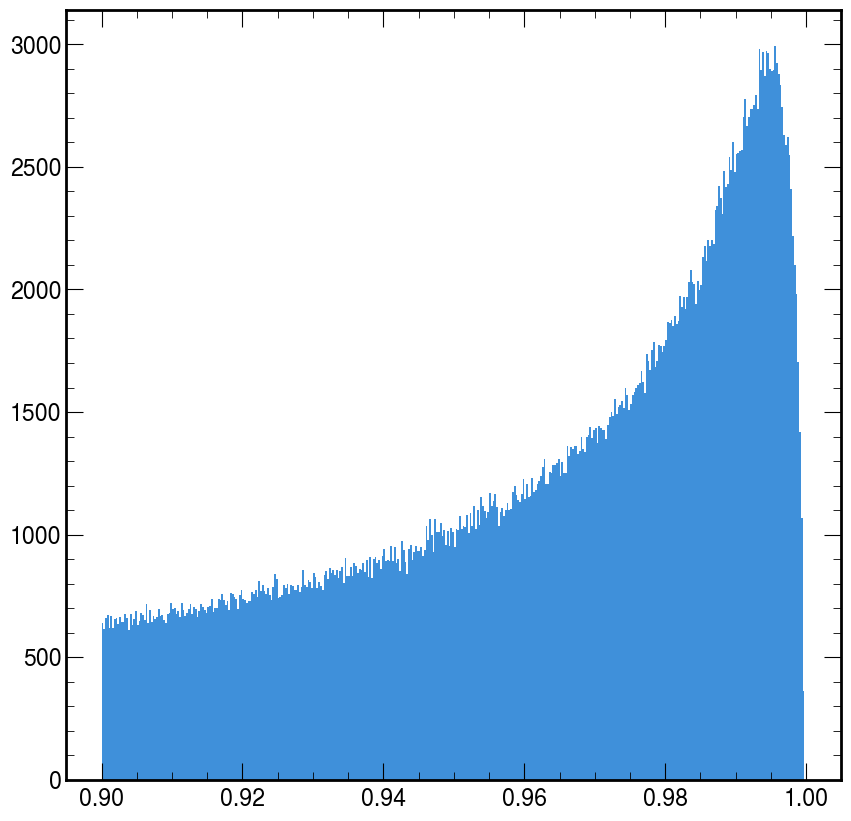

In [25]:
resample_ = 10
RESAMPLE = (resample_) * 10  # Set to False for no resampling, otherwise sets the number of times to duplicate gjet data for resampling

plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "mass_sculpting_resample")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

score_cuts = [0.0, 0.7, 0.99, 0.9984]
label_arr = [f'score above {score_cut}' for score_cut in score_cuts]
plot_vars = ['mass', 'dijet_mass', 'HHbbggCandidate_mass']

BDT_perf_resample = [
    {
        f'preds{score_cut}': copy.deepcopy({plot_var: list() for plot_var in plot_vars}) for score_cut in score_cuts
    } for fold_idx in range(len(bdt_train_dict))
]
GJet_preds = []
mean_values = {
    'gj': list(),
    'gg': list(),
    'tth': list()
}

for fold_idx in range(len(bdt_train_dict)):
    booster = xgb.Booster(param)
    booster.load_model(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))

    nonres_bool = (data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'sample_name'] == "GGJets") | (data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'sample_name'] == "GJetPt20To40") | (data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'sample_name'] == "GJetPt40")

    data_hlf_test = resample_grow_np(data_hlf_test_dict[f"fold_{fold_idx}"], nonres_bool, resample_)
    data_test_aux = resample_grow_pd(data_test_aux_dict[f"fold_{fold_idx}"], nonres_bool, resample_)
    weight_test = resample_grow_np(weight_test_dict[f"fold_{fold_idx}"], nonres_bool, resample_)
    weights_plot = resample_grow_np(weights_plot_test[f"fold_{fold_idx}"], nonres_bool, resample_)
    xgb_label_test = resample_grow_np(xgb_label_test_dict[f"fold_{fold_idx}"], nonres_bool, resample_)

    gg_bool = (data_test_aux.loc[:, 'sample_name'] == "GGJets")
    tth_bool = (data_test_aux.loc[:, 'sample_name'] == "ttHToGG")
    gj_bool = (data_test_aux.loc[:, 'sample_name'] == "GJetPt20To40") | (data_test_aux.loc[:, 'sample_name'] == "GJetPt40")
    hh_bool = (data_test_aux.loc[:, 'sample_name'] == "GluGluToHH")
    nonres_bool = (data_test_aux.loc[:, 'sample_name'] == "GGJets") | (data_test_aux.loc[:, 'sample_name'] == "GJetPt20To40") | (data_test_aux.loc[:, 'sample_name'] == "GJetPt40")


    for var_idx, plot_var in enumerate(plot_vars):

        plot_dirpath_ = os.path.join(plot_dirpath, plot_var)
        if not os.path.exists(plot_dirpath_):
            os.makedirs(plot_dirpath_)

        for _ in range(RESAMPLE // resample_):

            for particle_type in ['lead', 'sublead']:

                # gg_mvaID = data_hlf_test[
                #     gg_bool, 
                #     hlf_vars_columns_dict[f"fold_{fold_idx}"][f"{particle_type}_mvaID"]
                # ]
                # data_hlf_test[
                #     gj_bool, 
                #     hlf_vars_columns_dict[f"fold_{fold_idx}"][f"{particle_type}_mvaID"]
                # ] = resample_from_var(
                #     gg_mvaID, 
                #     weights_plot[gg_bool],
                #     np.sum(gj_bool),
                #     bins=190
                # )

                tth_pNetB = data_hlf_test[
                    tth_bool, 
                    hlf_vars_columns_dict[f"fold_{fold_idx}"][f"{particle_type}_bjet_btagPNetB"]
                ]
                data_hlf_test[
                    nonres_bool, 
                    hlf_vars_columns_dict[f"fold_{fold_idx}"][f"{particle_type}_bjet_btagPNetB"]
                ] = resample_from_var(
                    tth_pNetB, 
                    weights_plot[tth_bool],
                    np.sum(nonres_bool),
                    bins=100
                )

                # tth_sigmaE = data_hlf_test[
                #     tth_bool, 
                #     hlf_vars_columns_dict[f"fold_{fold_idx}"][f"{particle_type}_sigmaE_over_E"]
                # ]
                # data_hlf_test[
                #     gj_bool, 
                #     hlf_vars_columns_dict[f"fold_{fold_idx}"][f"{particle_type}_sigmaE_over_E"]
                # ] = resample_from_var(
                #     tth_sigmaE, 
                #     np.abs(weights_plot[tth_bool]),
                #     np.sum(gj_bool),
                #     bins=100
                # )
            # hh_dijet = data_hlf_test[
            #     hh_bool, 
            #     hlf_vars_columns_dict[f"fold_{fold_idx}"]["dijet_mass"]
            # ]
            # data_hlf_test[
            #     nonres_bool, 
            #     hlf_vars_columns_dict[f"fold_{fold_idx}"]["dijet_mass"]
            # ] = resample_from_var(
            #     hh_dijet, 
            #     np.abs(weights_plot[hh_bool]),
            #     np.sum(nonres_bool),
            #     bins=100
            # )

            nonres_ggf_preds = booster.predict(
                xgb.DMatrix(
                    data=data_hlf_test[nonres_bool], label=xgb_label_test[nonres_bool], 
                    weight=np.abs(weight_test)[nonres_bool],
                    missing=-999.0, feature_names=list(hlf_vars_columns_dict[f"fold_{fold_idx}"])
                ), 
                iteration_range=(0, booster.best_iteration+1)
            )[:, 0]

            # gg_ggf_preds = booster.predict(
            #     xgb.DMatrix(
            #         data=data_hlf_test[gg_bool], label=xgb_label_test[gg_bool], 
            #         weight=np.abs(weight_test)[gg_bool],
            #         missing=-999.0, feature_names=list(hlf_vars_columns_dict[f"fold_{fold_idx}"])
            #     ), 
            #     iteration_range=(0, booster.best_iteration+1)
            # )[:, 0]
            # tth_ggf_preds = booster.predict(
            #     xgb.DMatrix(
            #         data=data_hlf_test[tth_bool], label=xgb_label_test[tth_bool], 
            #         weight=np.abs(weight_test)[tth_bool],
            #         missing=-999.0, feature_names=list(hlf_vars_columns_dict[f"fold_{fold_idx}"])
            #     ), 
            #     iteration_range=(0, booster.best_iteration+1)
            # )[:, 0]

            if np.sum([len(GJet_preds[i]) for i in range(len(GJet_preds))]) < 100000:
                GJet_preds.append(nonres_ggf_preds[nonres_ggf_preds > 0.9])

            for score_cut in score_cuts:
                if len(BDT_perf_resample[fold_idx][f'preds{score_cut}'][plot_var]) >= 10000:
                    continue

                BDT_perf_resample[fold_idx][f'preds{score_cut}'][plot_var].append(
                    data_test_aux.loc[nonres_bool, plot_var].to_numpy()[nonres_ggf_preds > score_cut]
                )
        if fold_idx == 0 and plot_var == 'mass':
            plt.figure()
            plt.hist(np.concatenate(GJet_preds), bins=400, range=(0.9, 1.))
            plt.savefig(os.path.join(plot_dirpath_, "GJet_output_dist_with_resample0p9"))

        test_hists = [hist.Hist(VARIABLES[plot_var]).fill(var=np.concatenate(BDT_perf_resample[fold_idx][f'preds{score_cut}'][plot_var])) for score_cut in score_cuts]
        make_input_plot(
            plot_dirpath_, plot_var,
            test_hists, 
            fold_idx=fold_idx, labels=label_arr, 
            plot_prefix='test_non-res_scoreCut_'
        )

for var_idx, plot_var in enumerate(plot_vars):

    plot_dirpath_ = os.path.join(plot_dirpath, plot_var)
    if not os.path.exists(plot_dirpath_):
        os.makedirs(plot_dirpath_)

    test_hists = [hist.Hist(VARIABLES[plot_var]).fill(
        var=np.concatenate(
            [np.concatenate(BDT_perf_resample[fold_idx][f'preds{score_cut}'][plot_var]) for fold_idx in range(len(BDT_perf_resample))]
        )
    ) for score_cut in score_cuts]
    make_input_plot(
        plot_dirpath_, plot_var,
        test_hists, 
        fold_idx=None, labels=label_arr, 
        plot_prefix='test_non-res_scoreCut_'
    )


### Pre-Standardization

In [11]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "pre_std")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

label_arr_fold = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" val", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" val", MC_NAMES_PRETTY["ttHToGG"]+" test",
    # MC_NAMES_PRETTY["single-H"]+" train", MC_NAMES_PRETTY["single-H"]+" val", MC_NAMES_PRETTY["single-H"]+" test",
    # MC_NAMES_PRETTY["non-res"]+" train", MC_NAMES_PRETTY["non-res"]+" val", MC_NAMES_PRETTY["non-res"]+" test",
    MC_NAMES_PRETTY["VH"]+" train", MC_NAMES_PRETTY["VH"]+" val", MC_NAMES_PRETTY["VH"]+" test",
    MC_NAMES_PRETTY["non-res + ggFH + VBFH"]+" train", MC_NAMES_PRETTY["non-res + ggFH + VBFH"]+" val", MC_NAMES_PRETTY["non-res + ggFH + VBFH"]+" test",
]
# Loop over and plot the per-fold variables
for fold_idx in range(len(hlf_vars_columns_dict)):

    for var_name in hlf_vars_columns_dict['fold_0']:
        if var_name in {'puppiMET_eta'}:
            continue

        plot_dirpath_ = os.path.join(plot_dirpath, var_name)
        if not os.path.exists(plot_dirpath_):
            os.makedirs(plot_dirpath_)

        train_hists, val_hists, test_hists = {}, {}, {}
        for i, sample_name in enumerate(order):
            train_mask = xgb_label_train_dict[f'fold_{fold_idx}'] == i
            val_mask = xgb_label_val_dict[f'fold_{fold_idx}'] == i
            test_mask = xgb_label_test_dict[f'fold_{fold_idx}'] == i

            train_np = (
                data_df_dict[f'fold_{fold_idx}'].iloc[train_idxs_dict[f'fold_{fold_idx}']]
            ).loc[train_mask, var_name].to_numpy()
            val_np = (
                data_df_dict[f'fold_{fold_idx}'].iloc[val_idxs_dict[f'fold_{fold_idx}']]
            ).loc[val_mask, var_name].to_numpy()
            test_np = data_test_df_dict[f'fold_{fold_idx}'].loc[test_mask, var_name].to_numpy()

            train_hists[sample_name] = hist.Hist(VARIABLES[var_name]).fill(var=train_np)
            val_hists[sample_name] = hist.Hist(VARIABLES[var_name]).fill(var=val_np)
            test_hists[sample_name] = hist.Hist(VARIABLES[var_name]).fill(var=test_np)
    
            make_input_plot(
                plot_dirpath_, var_name,
                [train_hists[sample_name], val_hists[sample_name], test_hists[sample_name]], 
                fold_idx=fold_idx, labels=label_arr_fold[3*i : 3*(i+1)], plot_prefix=f'train_val_test_{sample_name}_'
            )
        for j, (plot_type, histdict) in enumerate([('train_', train_hists), ('val_', val_hists), ('test_', test_hists)]):
            make_input_plot(
                plot_dirpath_, var_name,
                [histdict[sample_name] for sample_name in order], 
                fold_idx=fold_idx, labels=label_arr_fold[j::3], plot_prefix=plot_type
            )


### Post-Standardization

In [12]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "post_std")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

label_arr_fold = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" val", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" val", MC_NAMES_PRETTY["ttHToGG"]+" test",
    # MC_NAMES_PRETTY["single-H"]+" train", MC_NAMES_PRETTY["single-H"]+" val", MC_NAMES_PRETTY["single-H"]+" test",
    # MC_NAMES_PRETTY["non-res"]+" train", MC_NAMES_PRETTY["non-res"]+" val", MC_NAMES_PRETTY["non-res"]+" test",
    MC_NAMES_PRETTY["VH"]+" train", MC_NAMES_PRETTY["VH"]+" val", MC_NAMES_PRETTY["VH"]+" test",
    MC_NAMES_PRETTY["non-res + ggFH + VBFH"]+" train", MC_NAMES_PRETTY["non-res + ggFH + VBFH"]+" val", MC_NAMES_PRETTY["non-res + ggFH + VBFH"]+" test",
]
# Loop over and plot the per-fold variables
for fold_idx in range(len(hlf_vars_columns_dict)):

    for var_idx, var_name in enumerate(hlf_vars_columns_dict['fold_0']):
        if var_name in {'puppiMET_eta'}:
            continue

        plot_dirpath_ = os.path.join(plot_dirpath, var_name)
        if not os.path.exists(plot_dirpath_):
            os.makedirs(plot_dirpath_)

        train_hists, val_hists, test_hists = {}, {}, {}
        for i, sample_name in enumerate(order):
            train_mask = xgb_label_train_dict[f'fold_{fold_idx}'] == i
            val_mask = xgb_label_val_dict[f'fold_{fold_idx}'] == i
            test_mask = xgb_label_test_dict[f'fold_{fold_idx}'] == i

            train_np = train_data_dict[f'fold_{fold_idx}'][train_mask, var_idx]
            val_np = val_data_dict[f'fold_{fold_idx}'][val_mask, var_idx]
            test_np = data_hlf_test_dict[f'fold_{fold_idx}'][test_mask, var_idx]

            train_hists[sample_name] = hist.Hist(VARIABLES_STD[var_name]).fill(var=train_np)
            val_hists[sample_name] = hist.Hist(VARIABLES_STD[var_name]).fill(var=val_np)
            test_hists[sample_name] = hist.Hist(VARIABLES_STD[var_name]).fill(var=test_np)
    
            make_input_plot(
                plot_dirpath_, var_name,
                [train_hists[sample_name], val_hists[sample_name], test_hists[sample_name]], 
                fold_idx=fold_idx, labels=label_arr_fold[3*i : 3*(i+1)], plot_prefix=f'train_val_test_{sample_name}_'
            )
        for j, (plot_type, histdict) in enumerate([('train_', train_hists), ('val_', val_hists), ('test_', test_hists)]):
            make_input_plot(
                plot_dirpath_, var_name,
                [histdict[sample_name] for sample_name in order], 
                fold_idx=fold_idx, labels=label_arr_fold[j::3], plot_prefix=plot_type
            )

### Save out new parquets for Yibo to run

In [ ]:
EVAL_DATA_ON_ALL_FOLDS = False

# load and pre-process the data
DATA_FILEPATHS_DICT = {
    'Data': [
        lpc_fileprefix+f"/Run3_2022preEE_merged_v3/Data_EraC/nominal/*", 
        lpc_fileprefix+f"/Run3_2022preEE_merged_v3/Data_EraD/nominal/*",
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/Data_EraE/nominal/*",
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/Data_EraF/nominal/*",
        lpc_fileprefix+f"/Run3_2022postEE_merged_v3/Data_EraG/nominal/*",
    ],
}

(
    NOTHING_IGNORE,
    DATA_data_df_dict, DATA_data_test_df_dict, 
    DATA_data_hlf_dict, DATA_label_dict,
    DATA_data_hlf_test_dict, DATA_label_test_dict, 
    DATA_hlf_vars_columns_dict,
    DATA_data_aux_dict, DATA_data_test_aux_dict
) = process_data(
    DATA_FILEPATHS_DICT, OUTPUT_DIRPATH, order=['Data'], mod_vals=MOD_VALS, k_fold_test=True,
    save=False, std_json_dirpath=OUTPUT_DIRPATH
)

BDT_DATA_preds = []

bdt_train_data_dict, bdt_test_data_dict = {}, {}
for fold_idx in range(len(DATA_label_test_dict)):
    
    bdt_train_data_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
        data=DATA_data_hlf_dict[f"fold_{fold_idx}"], label=DATA_label_dict[f"fold_{fold_idx}"], 
        missing=-999.0, feature_names=list(DATA_hlf_vars_columns_dict[f"fold_{fold_idx}"])
    )
    bdt_test_data_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
        data=DATA_data_hlf_test_dict[f"fold_{fold_idx}"], label=DATA_label_test_dict[f"fold_{fold_idx}"], 
        missing=-999.0, feature_names=list(DATA_hlf_vars_columns_dict[f"fold_{fold_idx}"])
    )

    booster = xgb.Booster(param)
    booster.load_model(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))

    if EVAL_DATA_ON_ALL_FOLDS:

        BDT_train_preds = booster.predict(
            bdt_train_data_dict[f"fold_{fold_idx}"], 
            iteration_range=(0, booster.best_iteration+1)
        )
        BDT_test_preds = booster.predict(
            bdt_test_data_dict[f"fold_{fold_idx}"], 
            iteration_range=(0, booster.best_iteration+1)
        )

        BDT_all_preds = np.concatenate([BDT_train_preds, BDT_test_preds])
        BDT_all_preds = BDT_all_preds[
            np.argsort(
                np.concatenate([DATA_data_aux_dict[f"fold_{fold_idx}"].loc[:, 'hash'].to_numpy(), DATA_data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'hash'].to_numpy()])
            )
        ].tolist()

        if fold_idx == 0:
            BDT_DATA_preds = copy.deepcopy(BDT_all_preds)
        else:
            BDT_DATA_preds += BDT_all_preds

            if fold_idx == len(DATA_label_test_dict) - 1:
                BDT_DATA_preds = BDT_DATA_preds / len(DATA_label_test_dict)
    else:

        BDT_DATA_preds.append(
            booster.predict(
                bdt_test_data_dict[f"fold_{fold_idx}"], 
                iteration_range=(0, booster.best_iteration+1)
            ).tolist()
        )

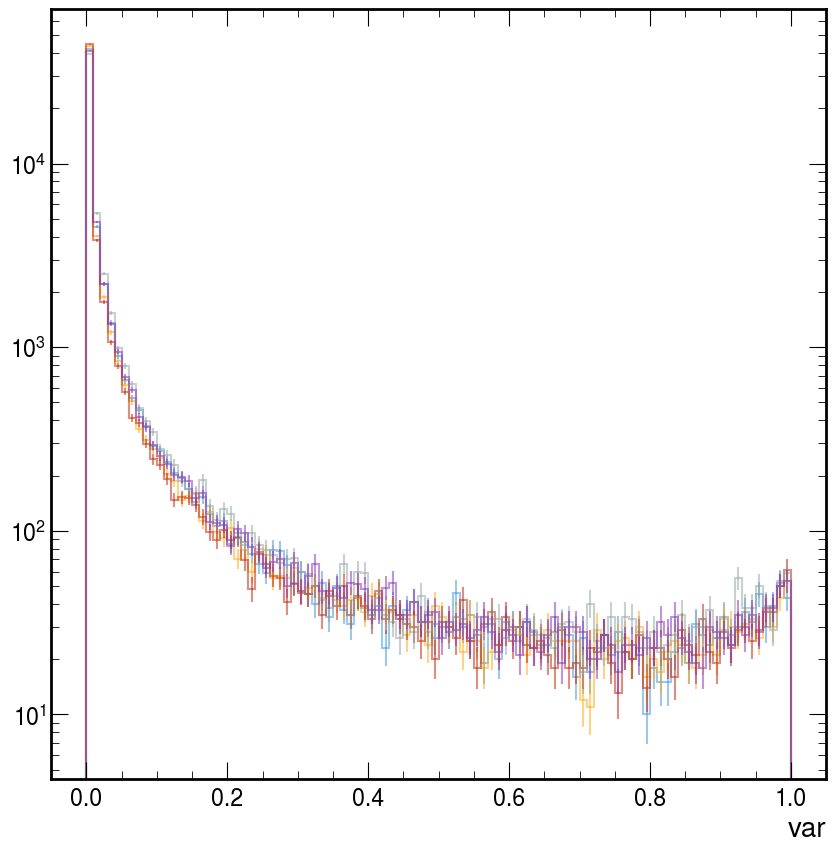

In [10]:
## Plot to show data labels look ok

plt.figure()

hist_axis = hist.axis.Regular(100, 0., 1., name='var', growth=False, underflow=False, overflow=False)

data_hists, data_plot_labels = [], []
for fold_idx in range(len(BDT_DATA_preds)):

    data_hists.append(
        hist.Hist(hist_axis, storage='weight').fill(
            var=np.array(BDT_DATA_preds[fold_idx])[:, 0],
        )
    )
    data_plot_labels.append(f"fold {fold_idx}")

hep.histplot(
    data_hists,
    alpha=0.5, density=False, histtype='step',
    label=data_plot_labels
)

plt.yscale('log')
plt.show()

In [ ]:
if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

# Sorts the predictions to map the output to the correct event
def sorted_preds(preds, data_aux, sample, sorted_preds=False):
    if not sorted_preds:
        flat_preds = np.concatenate([preds[fold_idx] for fold_idx in range(len(data_aux))])
        preds_sort = np.argsort(
            np.concatenate([data_aux[f"fold_{fold_idx}"].loc[:, 'hash'].to_numpy() for fold_idx in range(len(data_aux))])
        )
    else:
        flat_preds = preds
        preds_sort = np.arange(len(flat_preds))

    sample_sort = np.argsort(np.argsort(
        ak.to_numpy(sample['hash'], allow_missing=False)
    ))

    return flat_preds[preds_sort][sample_sort]

# Load parquet files #
for i, sample_name in enumerate(order):
    for dirpath in DATA_FILEPATHS_DICT[sample_name]:
        parquet_filepath = glob.glob(dirpath)[0]
        sample = ak.from_parquet(parquet_filepath)

        sample_preds = [
            np.array(BDT_perf[sample_name]['preds'][fold_idx])[bdt_test_dict[f"fold_{fold_idx}"].get_label() == i] for fold_idx in range(len(BDT_perf[sample_name]['preds']))
        ]
        sample_data_aux = {
            f"fold_{fold_idx}": data_test_aux_dict[f"fold_{fold_idx}"].loc[bdt_test_dict[f"fold_{fold_idx}"].get_label() == i] for fold_idx in range(len(BDT_perf[sample_name]['preds']))
        }

        sample['MultiBDT_output'] = sorted_preds(
            sample_preds, sample_data_aux, sample
        )

        dest_filepath = parquet_filepath[:parquet_filepath.find('v3')+2] + '_MultiBDT_output' + parquet_filepath[parquet_filepath.find('v3')+2:parquet_filepath.rfind('.')] + '_MultiBDT_output' + parquet_filepath[parquet_filepath.rfind('.'):]
        if not os.path.exists(dest_filepath[:dest_filepath.rfind('/')]):
            os.makedirs(dest_filepath[:dest_filepath.rfind('/')])
        print(dest_filepath)
        print('='*60)
        merged_parquet = ak.to_parquet(sample, dest_filepath)

if 'BDT_DATA_preds' in globals():

    for dirpath in DATA_FILEPATHS_DICT['Data']:
        parquet_filepath = glob.glob(dirpath)[0]
        data_sample = ak.from_parquet(parquet_filepath)

        data_sample_preds = [
            np.array(BDT_DATA_preds[fold_idx]) for fold_idx in range(len(BDT_DATA_preds))
        ]
        data_sample_aux = {
            f"fold_{fold_idx}": DATA_data_test_aux_dict[f"fold_{fold_idx}"] for fold_idx in range(len(BDT_DATA_preds))
        }

        sample['MultiBDT_output'] = sorted_preds(
            data_sample_preds, data_sample_aux, data_sample,
            sorted_preds=True if EVAL_DATA_ON_ALL_FOLDS else False
        )

        dest_filepath = parquet_filepath[:parquet_filepath.find('v3')+2] + '_MultiBDT_output' + parquet_filepath[parquet_filepath.find('v3')+2:parquet_filepath.rfind('.')] + '_MultiBDT_output' + parquet_filepath[parquet_filepath.rfind('.'):]
        if not os.path.exists(dest_filepath[:dest_filepath.rfind('/')]):
            os.makedirs(dest_filepath[:dest_filepath.rfind('/')])
        print(dest_filepath)
        print('='*60)
        merged_parquet = ak.to_parquet(sample, dest_filepath)

/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v1/Run3_2022preEE_merged_v3_MultiBDT_output/GluGluToHH/nominal/GluGluToHH_nominal_MultiBDT_output.parquet
/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v1/Run3_2022postEE_merged_v3_MultiBDT_output/GluGluToHH/nominal/GluGluToHH_nominal_MultiBDT_output.parquet
/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v1/Run3_2022preEE_merged_v3_MultiBDT_output/ttHToGG/nominal/ttHToGG_nominal_MultiBDT_output.parquet
/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v1/Run3_2022postEE_merged_v3_MultiBDT_output/ttHToGG/nominal/ttHToGG_nominal_MultiBDT_output.parquet
/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v1/Run3_2022preEE_merged_v3_MultiBDT_output/GluGluHToGG/nominal/GluGluHToGG_nominal_MultiBDT_output.parquet
/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v1/Run3_2022postEE_merged_v3_MultiBDT_output/GluGluHToGG/nominal/GluGluHToGG_nominal_Mul